In [ ]:
! git clone https://github.com/Salsasharkz/kaggle_intel_classification_data

Cloning into 'kaggle_intel_classification_data'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 24316 (delta 0), reused 2 (delta 0), pack-reused 24313
Receiving objects: 100% (24316/24316), 360.32 MiB | 36.15 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (24338/24338), done.


In [ ]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import gridspec 
import requests
from pathlib import Path
from PIL import Image
from io import BytesIO
from sklearn.model_selection import train_test_split
from skimage import feature
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import BatchNormalization, Lambda, Conv2D, Dropout, MaxPooling2D, Dense, Flatten, Input, GlobalAveragePooling2D, ZeroPadding2D, Activation, Reshape
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.ensemble import RandomForestClassifier
from multiprocessing import cpu_count

In [ ]:
# Import and adjust matplotlib dpi scaling for high res displays
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

# Intel Image Classificaion
DATA 607

Ryan Johnston, <br>
Scott Pellegrino, <br>
Troy Stolz <br>


## Introduction and Background

Image recognition and computer vision are becomming more and more prevalent in day-to-day life. More vehicle manufacturers are adding saftey features which identify hazards before drivers are aware of them (Demlehner et al, 2021), door bells are learning to recognize and remember who comes to your door (Kairinos, 2019), and it's possible to tell if your pet is happy based on a single photograph (Aickelin, 2020). Moravec's Paradox states that it is difficult to train a computer to do a task that huamns find relatively easy, while more complex tasks, such as linear algebra, are easy to train (Moravec 1988). The development of deep learning has made this process much easier over the past two decades. Deep learning uses artificial neural networks, a collection of nodes that are connected like neurons, to process data (LeCun et al. 2015). It has been seen that convolutional neural network (CNN) models work incredibly well when properly constructed and trained. 

In this study, we aim to produce predictive models which are able to reliably categorize images into six distinct categories. The models implemented were Random Forests and Convolutional Neural Networks (CNN). 


## Data

The data selected for this investigation was the Intel Image Classification dataset. The dataset contains roughly 17,000 categorized 150x150 pixel images belonging to categoreis of "buildings", "forest", "glacier", "mountain", "sea", and "street". There are between 2,600 and 3,000 images for each category. The dataset was retrieved from Kaggle and originally part of hte Intel Scene Classification Challenge (Intel Challenge 2018).

In [ ]:
PATH = Path("kaggle_intel_classification_data/Data/seg_train")
TARGET_SIZE = (150, 150)

data = {"f": [], "x": [], "y": []}
for f in PATH.iterdir():
  for sub in f.iterdir():
    if sub.suffix == ".jpg":
      data["f"].append(sub)
      data["x"].append(str(sub))
      data["y"].append(str(f).split('/')[-1])
df_train = pd.DataFrame(data=data)

PATH = Path("kaggle_intel_classification_data/Data/seg_test")
data = {"f": [], "x": [], "y": []}
for f in PATH.iterdir():
  for sub in f.iterdir():
    if sub.suffix == ".jpg":
      data["f"].append(sub)
      data["x"].append(str(sub))
      data["y"].append(str(f).split('/')[-1])
df_test = pd.DataFrame(data=data)

df_all =df_train.append(df_test)
df_all.reset_index(drop = True, inplace = True)

display(df_all.shape)
display(df_all.head())

(17034, 3)

f  ...       y
0  kaggle_intel_classification_data/Data/seg_trai...  ...  street
1  kaggle_intel_classification_data/Data/seg_trai...  ...  street
2  kaggle_intel_classification_data/Data/seg_trai...  ...  street
3  kaggle_intel_classification_data/Data/seg_trai...  ...  street
4  kaggle_intel_classification_data/Data/seg_trai...  ...  street

[5 rows x 3 columns]

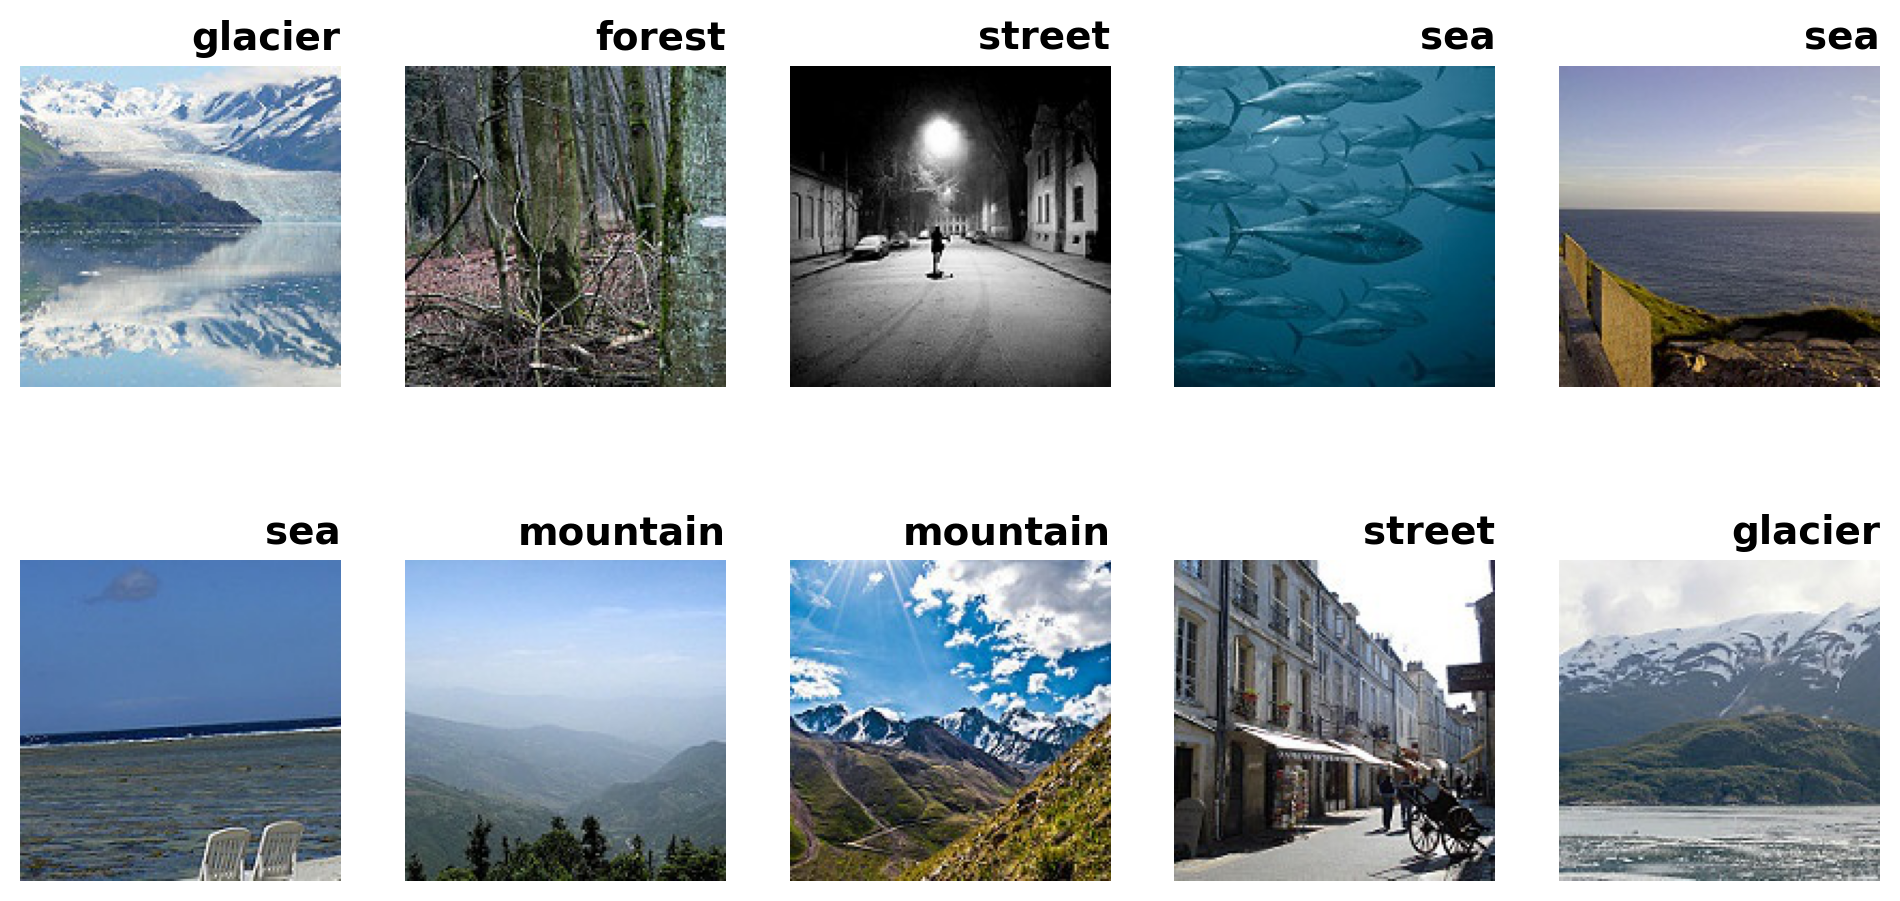

In [ ]:
rows = 2
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
sub_df = df_train.sample(rows*cols)
for i in range(rows):
    for j in range(cols):
        k = cols*i + j
        f = sub_df.iloc[k].f
        y = sub_df.iloc[k].y
        img = load_img(f, target_size=TARGET_SIZE)
        axes[i][j].imshow(img)
        axes[i][j].set_title(f"{y}", fontweight="bold", fontsize=14, loc="right")
        axes[i][j].set_axis_off()
plt.show()

## Methodology


### Random Forest

The first classification model constructed was a Random Forest Classifier. The random forest classifer constructs multiple decision tree classifiers and reports the majority decision. For each constructed tree, the points where it branches, or decisions are made, will differ slightly. While training, the model will adjust the decision points and values to minimze the sum of square error (SSE). One drawback with this model, for this investigation, is that the variety of images within the dataset cause complications in the model fitting process. This means that an entire image cannot be directly provided to the model in a meaningful way.

As the data available were only images, measurable features within the images needed to be extracted. The most obvious feature available was image colour. Several approaches were made when deciding how to use the image color. To quantify an image in multiple ways, the dominant colour, and "colourfulness" were used. In addition to these, some textures of the greyscaled image were determined. Further to the greyscale textures, a Canny edge detection filter was applied to the image and additional measurable features extracted from that. 


#### Dominant Colour

To determine dominant colour, the image data was first re-shaped to a 1-dimensional vector for each rgb channel. For example, a MxN pixel colour image would be reshaped into a (M*N)x3 matrix. From here, a k-means clustering is carried out on the newly created matrix. Once a pre-determined number of steps are completed, or an accuracy is satisifed, the largest grouping is determined to be the dominant colour. Examples of this are illustrated within the results and discussion below.

In [ ]:
# Method presented by "Tonechas"
# https://stackoverflow.com/questions/43111029/how-to-find-the-average-colour-of-an-image-in-python-with-opencv

def find_dom_col(image, n_colors = 2):
  image = np.array(image) # precaution to ensure image in needed format
  pixels = np.float32(image.reshape(-1, 3))
  
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1) # set stopping criteria 
  flags = cv2.KMEANS_RANDOM_CENTERS # Where to pick initial cluster starting points
  
  _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags) # cluster the colours
  _, counts = np.unique(labels, return_counts=True) # find most common (dominant) colour
      
  dominant = palette[np.argmax(counts)]
  return dominant

#### Colorfulness

To determine the colourfulness of each image, the method determined by Hasler and Susstrunk was implemented (Hasler & Susstrunk, 2003). They conducted an experiment where they asked participants to rate how "colourful" an image was. From these results, they determined a way to quantify colourfulness based on pixel values.

To start, the difference between the red and green band, and the yellow and blue band is determined

$$
rg = R-G
$$
$$
yb = \frac{1}{2}(R+G)-B
$$

Next, the standard deviations($\sigma$) and mean ($\mu$) values of $rg$ and $yb$ differences are used to calculate the standard deviation and mean for both differences.

$$
\sigma_{rgyb} = \sqrt{\sigma_{rg}^2+\sigma_{yb}^2}
$$
$$
\mu_{rgyb} = \sqrt{\mu_{rg}^2+\mu_{yb}^2}
$$

Finally, the colourfulness metric is calulated simply from these values.

$$
\hat{M} =\sigma_{rgyb} + 0.3\mu_{rgyb}
$$




In [ ]:
def colorfulness(image):
  image = np.array(image)
  r,g,b = [image[:,:,i] for i in range(image.shape[2])]
  
  rg = np.absolute(r-g)
  yb = np.absolute(0.5*(r+g)-b)
  (rg_mean,rg_std) = (np.mean(rg), np.std(rg))
  (yb_mean,yb_std) = (np.mean(yb), np.std(yb))
  
  std_root = np.sqrt((rg_std**2)+(yb_std**2))
  mean_root = np.sqrt((rg_mean**2)+(yb_mean**2))
  
  return(std_root+(0.3*mean_root))

#### Greyscale Textures

To extract textures, the image was first made greyscale. This was done by calculating the luminance for each pixel, as shown in the following equation:

$$
Luminance = 0.3R+0.59G+0.11B
$$

Where $R$, $G$, and $B$ are the red, blue, and green bands of the image. 

Once in greyscale, a grey-level co-occurrence matrix (GLCM) was produced. This matrix contains the distribution of co-occurring pixel values across the image, for a given offset. Using this matrix, several texture properties are calculable. The texture properties used were dissimilarity and correlation. They are calculated as follows:

$$
Dissimilarity = \sum_{i,j=0}^{levels-1} P_{i,j}|i-j|
$$

$$
Correlation = \sum_{i,j =0}^{levels-1}P_{i,j}\left[\frac{(i-\mu_i)(j-\mu_j)}{\sqrt{(\sigma_i^2)(\sigma_j^2)}}\right]
$$

In these equations, $P_{i,j}$ is the (i,j) pixel value, and $\mu$ and $\sigma$ are the respective means and standard deviations.

In [ ]:
def lumin(image):
    image = np.array(image)
    shape = image.shape[0:2]
    r,g,b = [image[:,:,i] for i in range(3)]
    lum = (0.3*r+0.59*g+0.11*b).reshape(-1,1)
    lum = [int(i) for i in lum]
    return np.array(lum).reshape(shape)

#### Canny Edge Detection Filter

To quantify the presence of vertical or horizonatal features, the maximum of the mean values along each filtered axis were used. To support this, the standard deviation of the filtered pixel intensities was also recorded along the same axes.

The Canny filter works as follows:

- A gaussian blur, with intensity $\sigma$ is applied to the greyscale image;
- The magnitude of the intensity gradients are determined using Sobel filters $G_x$, $G_y$;
- The angle of the directional gradients are determined
- Non-maximum suppression is applied to the edges
    - This finds the maximum pixel value in an edge
    - pixels along the directional gradient are compared
    - If a pixel has a value larger than both directions of the directional gradient it is kept
- Apply threshold to determine edges
    - Edge intensity values above a threshold will indicate a strong edge
    - Edge intensity values below a threshold will indicate a false edge
    - Edge intensity values between these upper and lower thresholds will indicate a weak edge
- Edge tracking by Hysteresis
    - Weak edges connected to strong edges are edges
    - "Free floating" weak edges are not edges
   
Sobel Filters:
$$
G_x  =
\begin{bmatrix} -1 & 0 & 1 \\ -1 & 0 & 2 \\ -1 & 0 & 1 \\ \end{bmatrix}
\space, \hspace{2em}
G_y = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \\ \end{bmatrix}
$$

Gradient Magnitude:
$$
|G| = \sqrt{G_x^2+G_y^2}
$$

Gradient Angle:
$$
\angle G = arctan(G_y/G_x)
$$

#### Image Segmentation
As it may be that portions of an image are more characteristic than others, each image was split equally into 16 smaller images. For each of these images, all of the mentioned feature extractions were conducted. This was to improve the liklihood that, should a characteristic detail be found in a particular portion of an image, it would not be lost due its relative size.

In [ ]:
def segment_image(im):
    size = im.shape[0]
    i1 = int(size/4)
    i2 = i1*2
    i3 = i1*3
    
    if len(im.shape) == 3:
        im_00 = im[:i1,:i1,:]
        im_01 = im[:i1,i1:i2,:]
        im_02 = im[:i1,i2:i3,:]
        im_03 = im[:i1,i3:,:]
        im_10 = im[i1:i2,:i1,:]
        im_11 = im[i1:i2,i1:i2,:]
        im_12 = im[i1:i2,i2:i3,:]
        im_13 = im[i1:i2,i3:,:]
        im_20 = im[i2:i3,:i1,:]
        im_21 = im[i2:i3,i1:i2,:]
        im_22 = im[i2:i3,i2:i3,:]
        im_23 = im[i2:i3,i3:,:]
        im_30 = im[i3:,:i1,:]
        im_31 = im[i3:,i1:i2,:]
        im_32 = im[i3:,i2:i3,:]
        im_33 = im[i3:,i3:,:]
    elif len(im.shape) == 2:
        im_00 = im[:i1,:i1]
        im_01 = im[:i1,i1:i2]
        im_02 = im[:i1,i2:i3]
        im_03 = im[:i1,i3:]
        im_10 = im[i1:i2,:i1]
        im_11 = im[i1:i2,i1:i2]
        im_12 = im[i1:i2,i2:i3]
        im_13 = im[i1:i2,i3:]
        im_20 = im[i2:i3,:i1]
        im_21 = im[i2:i3,i1:i2]
        im_22 = im[i2:i3,i2:i3]
        im_23 = im[i2:i3,i3:]
        im_30 = im[i3:,:i1]
        im_31 = im[i3:,i1:i2]
        im_32 = im[i3:,i2:i3]
        im_33 = im[i3:,i3:]
    else:
        print("Invalid image format.")
        return
    
    return np.stack([im_00, im_01, im_02, im_03,
                     im_10, im_11, im_12, im_13,
                     im_20, im_21, im_22, im_23,
                     im_30, im_31, im_32, im_33])

### Convolutional Neural Network

One of the models that we will attempt to construct is a convolutional neural network using the tensorflow and keras libraries. A neural network is a model that takes inspiration from the brain, it is composed of layers of which at least one is hidden. It consists of simple connected units (or neurons) followed by non linearities. This means that a convolutional neural network is a neural network in which at least one layer is a convolutional layer. A typical convolutional neural network consists of some combination of convolutional layers, pooling layers, and dense layers. These types of neural networks tend to have great success in image recognition problems such as the one we are trying to solve. 

A convolutional operation follows a two step mathematical approach:
1. Element-wise multiplication of the convolutional filter and a slice of an input matrix.
2. The summation of all the values in the resulting product matrix
Convolutional layers consist of a series of convolutional operations, each acting on a different slice of the input matrix

A pooling operation is typically performed after a convolution. This is done by again dividing the matrix into slices and then slides the convolutional operation by strides. For our purposes we will be using max pooling which selects the largest value out of the slices.

A dense layer is a synonym for a fully connected layer. This is the hidden layer in which each node is connected to every node in the subsequent hidden layer. Since we are trying to predict six different categories our final dense layer will be of size six.

## Results and Discussion

### Random Forest

Although the data was provided having separate training and testing subsets, when approaching the Random Forest model, all images were combined for easier feature extraction. Unique training and testing subsets were re-created when required.

Before being able to construct a random forest model, the previously mentioned features need to be extracted and quantified from each image. Following the outlined methods, each feature was extracted resulting in 170 measured parameters per image to be used for classification. For simplicity, we have saved a completed $.csv$ file of the data as to calculate all parameters for the dataset is fairly time consuming.     


In [ ]:
try:
    col_df =pd.read_csv('kaggle_intel_classification_data/colour_breakdown.csv') #load the already filled dataframe
    print(f'Loaded dataframe with {col_df.shape[0]} rows and {col_df.shape[1]} columns')
except:
    print('File not loaded. Population new Dataframe.')
    # This calculates ~3 million values from all the images. 
          
    # Initialize the Dataframe
    col_df = pd.DataFrame(columns=('fname','cat', 
                                   
                                   #colorfulness measure
                                   'colorfulness',
                                   'colorfulness_00','colorfulness_01','colorfulness_02','colorfulness_03',
                                   'colorfulness_10','colorfulness_11','colorfulness_12','colorfulness_13',
                                   'colorfulness_20','colorfulness_21','colorfulness_22','colorfulness_23',
                                   'colorfulness_30','colorfulness_31','colorfulness_32','colorfulness_33',
            
                                    # Dominant colour
                                   'dominant_r','dominant_g','dominant_b',
                                   'dominant_r_00','dominant_g_00','dominant_b_00',
                                   'dominant_r_01','dominant_g_01','dominant_b_01',
                                   'dominant_r_02','dominant_g_02','dominant_b_02',
                                   'dominant_r_03','dominant_g_03','dominant_b_03',
                                   
                                   'dominant_r_10','dominant_g_10','dominant_b_10',
                                   'dominant_r_11','dominant_g_11','dominant_b_11',
                                   'dominant_r_12','dominant_g_12','dominant_b_12',
                                   'dominant_r_13','dominant_g_13','dominant_b_13',
                                   
                                   'dominant_r_20','dominant_g_20','dominant_b_20',
                                   'dominant_r_21','dominant_g_21','dominant_b_21',
                                   'dominant_r_22','dominant_g_22','dominant_b_22',
                                   'dominant_r_23','dominant_g_23','dominant_b_23',
                                   
                                   'dominant_r_30','dominant_g_30','dominant_b_30',
                                   'dominant_r_31','dominant_g_31','dominant_b_31',
                                   'dominant_r_32','dominant_g_32','dominant_b_32',
                                   'dominant_r_33','dominant_g_33','dominant_b_33',
                                   
                                   # Texture dissimilarity                                 
                                   'dissimilar',
                                   'dissimilar_00','dissimilar_01','dissimilar_02','dissimilar_03',
                                   'dissimilar_10','dissimilar_11','dissimilar_12','dissimilar_13',
                                   'dissimilar_20','dissimilar_21','dissimilar_22','dissimilar_23',
                                   'dissimilar_30','dissimilar_31','dissimilar_32','dissimilar_33',
                                   
                                   # Texture correlation
                                   'correlation',
                                   'correlation_00','correlation_01','correlation_02','correlation_03',
                                   'correlation_10','correlation_11','correlation_12','correlation_13',
                                   'correlation_20','correlation_21','correlation_22','correlation_23',
                                   'correlation_30','correlation_31','correlation_32','correlation_33',
                                   
                                   
                                   'canny_mean_x', 'canny_mean_y',
                                   # Canny edge detection maximum mean - x axis
                                   'canny_mean_x_00','canny_mean_x_01','canny_mean_x_02','canny_mean_x_03',
                                   'canny_mean_x_10','canny_mean_x_11','canny_mean_x_12','canny_mean_x_13',
                                   'canny_mean_x_20','canny_mean_x_21','canny_mean_x_22','canny_mean_x_23',
                                   'canny_mean_x_30','canny_mean_x_31','canny_mean_x_32','canny_mean_x_33',
                                   
                                   # Canny edge detection maximum mean - y axis
                                   'canny_mean_y_00','canny_mean_y_01','canny_mean_y_02','canny_mean_y_03',
                                   'canny_mean_y_10','canny_mean_y_11','canny_mean_y_12','canny_mean_y_13',
                                   'canny_mean_y_20','canny_mean_y_21','canny_mean_y_22','canny_mean_y_23',
                                   'canny_mean_y_30','canny_mean_y_31','canny_mean_y_32','canny_mean_y_33',
                                   
                                   
                                   'canny_std_x', 'canny_std_y',
                                   # Canny edge detection maximum stdev - x axis
                                   'canny_std_x_00','canny_std_x_01','canny_std_x_02','canny_std_x_03',
                                   'canny_std_x_10','canny_std_x_11','canny_std_x_12','canny_std_x_13',
                                   'canny_std_x_20','canny_std_x_21','canny_std_x_22','canny_std_x_23',
                                   'canny_std_x_30','canny_std_x_31','canny_std_x_32','canny_std_x_33',
                                   # Canny edge detection maximum stdev - y axis
                                   'canny_std_y_00','canny_std_y_01','canny_std_y_02','canny_std_y_03',
                                   'canny_std_y_10','canny_std_y_11','canny_std_y_12','canny_std_y_13',
                                   'canny_std_y_20','canny_std_y_21','canny_std_y_22','canny_std_y_23',
                                   'canny_std_y_30','canny_std_y_31','canny_std_y_32','canny_std_y_33',
                                  ))
    
    col_df.fname = [k.split('\\')[-1] for k in df_all.x] # fill file name
    col_df.cat = df_all.y # fill category
    
    # begin calculations
    for i in range(len(df_all)):
        im  = np.array(load_img(df_all.f[i], target_size=(TARGET_SIZE))) # load image
        segs = segment_image(im) # create segments
        
        #calculate colourfulness
        col_df.colorfulness.iloc[i] = colorfulness(im)
        col_df.colorfulness_00.iloc[i] = colorfulness(segs[0,:,:,:])
        col_df.colorfulness_01.iloc[i] = colorfulness(segs[1,:,:,:])
        col_df.colorfulness_02.iloc[i] = colorfulness(segs[2,:,:,:])
        col_df.colorfulness_03.iloc[i] = colorfulness(segs[3,:,:,:])
        
        col_df.colorfulness_10.iloc[i] = colorfulness(segs[4,:,:,:])
        col_df.colorfulness_11.iloc[i] = colorfulness(segs[5,:,:,:])
        col_df.colorfulness_12.iloc[i] = colorfulness(segs[6,:,:,:])
        col_df.colorfulness_13.iloc[i] = colorfulness(segs[7,:,:,:])
        
        col_df.colorfulness_20.iloc[i] = colorfulness(segs[8,:,:,:])
        col_df.colorfulness_21.iloc[i] = colorfulness(segs[9,:,:,:])
        col_df.colorfulness_22.iloc[i] = colorfulness(segs[10,:,:,:])
        col_df.colorfulness_23.iloc[i] = colorfulness(segs[11,:,:,:])
        
        col_df.colorfulness_30.iloc[i] = colorfulness(segs[12,:,:,:])
        col_df.colorfulness_31.iloc[i] = colorfulness(segs[13,:,:,:])
        col_df.colorfulness_32.iloc[i] = colorfulness(segs[14,:,:,:])
        col_df.colorfulness_33.iloc[i] = colorfulness(segs[15,:,:,:])
        
        # Calculate dominant Colours       
        col_df.dominant_r.iloc[i],col_df.dominant_g.iloc[i],col_df.dominant_b.iloc[i] = find_dom_col(im)
        col_df.dominant_r_00.iloc[i],col_df.dominant_g_00.iloc[i],col_df.dominant_b_00.iloc[i], = find_dom_col(segs[0,:,:,:])
        col_df.dominant_r_01.iloc[i],col_df.dominant_g_01.iloc[i],col_df.dominant_b_01.iloc[i], = find_dom_col(segs[1,:,:,:])
        col_df.dominant_r_02.iloc[i],col_df.dominant_g_02.iloc[i],col_df.dominant_b_02.iloc[i], = find_dom_col(segs[2,:,:,:])
        col_df.dominant_r_03.iloc[i],col_df.dominant_g_03.iloc[i],col_df.dominant_b_03.iloc[i], = find_dom_col(segs[3,:,:,:])
        
        col_df.dominant_r_10.iloc[i],col_df.dominant_g_10.iloc[i],col_df.dominant_b_10.iloc[i], = find_dom_col(segs[4,:,:,:])
        col_df.dominant_r_11.iloc[i],col_df.dominant_g_11.iloc[i],col_df.dominant_b_11.iloc[i], = find_dom_col(segs[5,:,:,:])
        col_df.dominant_r_12.iloc[i],col_df.dominant_g_12.iloc[i],col_df.dominant_b_12.iloc[i], = find_dom_col(segs[6,:,:,:])
        col_df.dominant_r_13.iloc[i],col_df.dominant_g_13.iloc[i],col_df.dominant_b_13.iloc[i], = find_dom_col(segs[7,:,:,:])
        
        col_df.dominant_r_20.iloc[i],col_df.dominant_g_20.iloc[i],col_df.dominant_b_20.iloc[i], = find_dom_col(segs[8,:,:,:])
        col_df.dominant_r_21.iloc[i],col_df.dominant_g_21.iloc[i],col_df.dominant_b_21.iloc[i], = find_dom_col(segs[9,:,:,:])
        col_df.dominant_r_22.iloc[i],col_df.dominant_g_22.iloc[i],col_df.dominant_b_22.iloc[i], = find_dom_col(segs[10,:,:,:])
        col_df.dominant_r_23.iloc[i],col_df.dominant_g_23.iloc[i],col_df.dominant_b_23.iloc[i], = find_dom_col(segs[11,:,:,:])
        
        col_df.dominant_r_30.iloc[i],col_df.dominant_g_30.iloc[i],col_df.dominant_b_30.iloc[i], = find_dom_col(segs[12,:,:,:])
        col_df.dominant_r_31.iloc[i],col_df.dominant_g_31.iloc[i],col_df.dominant_b_31.iloc[i], = find_dom_col(segs[13,:,:,:])
        col_df.dominant_r_32.iloc[i],col_df.dominant_g_32.iloc[i],col_df.dominant_b_32.iloc[i], = find_dom_col(segs[14,:,:,:])
        col_df.dominant_r_33.iloc[i],col_df.dominant_g_33.iloc[i],col_df.dominant_b_33.iloc[i], = find_dom_col(segs[15,:,:,:])
        
        # greyscale the image and re-segment
        im = lumin(im)
        segs = segment_image(im)
        # generate grey-level co-occurrence matricies
        glcm_im = feature.greycomatrix(im, distances=[5], angles=[0], levels = 256, symmetric = True, normed = True)
        glcm_im00 = feature.greycomatrix(segs[0,:,:], distances=[5], angles=[0], levels = 256, symmetric = True, normed = True)
        glcm_im01 = feature.greycomatrix(segs[1,:,:], distances=[5], angles=[0], levels = 256, symmetric = True, normed = True)
        glcm_im02 = feature.greycomatrix(segs[2,:,:], distances=[5], angles=[0], levels = 256, symmetric = True, normed = True)
        glcm_im03 = feature.greycomatrix(segs[3,:,:], distances=[5], angles=[0], levels = 256, symmetric = True, normed = True)
        glcm_im10 = feature.greycomatrix(segs[4,:,:], distances=[5], angles=[0], levels = 256, symmetric = True, normed = True)
        glcm_im11 = feature.greycomatrix(segs[5,:,:], distances=[5], angles=[0], levels = 256, symmetric = True, normed = True)
        glcm_im12 = feature.greycomatrix(segs[6,:,:], distances=[5], angles=[0], levels = 256, symmetric = True, normed = True)
        glcm_im13 = feature.greycomatrix(segs[7,:,:], distances=[5], angles=[0], levels = 256, symmetric = True, normed = True)
        glcm_im20 = feature.greycomatrix(segs[8,:,:], distances=[5], angles=[0], levels = 256, symmetric = True, normed = True)
        glcm_im21 = feature.greycomatrix(segs[9,:,:], distances=[5], angles=[0], levels = 256, symmetric = True, normed = True)
        glcm_im22 = feature.greycomatrix(segs[10,:,:], distances=[5], angles=[0], levels = 256, symmetric = True, normed = True)
        glcm_im23 = feature.greycomatrix(segs[11,:,:], distances=[5], angles=[0], levels = 256, symmetric = True, normed = True)
        glcm_im30 = feature.greycomatrix(segs[12,:,:], distances=[5], angles=[0], levels = 256, symmetric = True, normed = True)
        glcm_im31 = feature.greycomatrix(segs[13,:,:], distances=[5], angles=[0], levels = 256, symmetric = True, normed = True)
        glcm_im32 = feature.greycomatrix(segs[14,:,:], distances=[5], angles=[0], levels = 256, symmetric = True, normed = True)
        glcm_im33 = feature.greycomatrix(segs[15,:,:], distances=[5], angles=[0], levels = 256, symmetric = True, normed = True)
        
        # Calculate dissimilarity
        col_df.dissimilar.iloc[i] = feature.greycoprops(glcm_im, 'dissimilarity')[0,0]
        col_df.dissimilar_00.iloc[i] = feature.greycoprops(glcm_im00, 'dissimilarity')[0,0]
        col_df.dissimilar_01.iloc[i] = feature.greycoprops(glcm_im01, 'dissimilarity')[0,0]
        col_df.dissimilar_02.iloc[i] = feature.greycoprops(glcm_im02, 'dissimilarity')[0,0]
        col_df.dissimilar_03.iloc[i] = feature.greycoprops(glcm_im03, 'dissimilarity')[0,0]
        
        col_df.dissimilar_10.iloc[i] = feature.greycoprops(glcm_im10, 'dissimilarity')[0,0]
        col_df.dissimilar_11.iloc[i] = feature.greycoprops(glcm_im11, 'dissimilarity')[0,0]
        col_df.dissimilar_12.iloc[i] = feature.greycoprops(glcm_im12, 'dissimilarity')[0,0]
        col_df.dissimilar_13.iloc[i] = feature.greycoprops(glcm_im13, 'dissimilarity')[0,0]
        
        col_df.dissimilar_20.iloc[i] = feature.greycoprops(glcm_im20, 'dissimilarity')[0,0]
        col_df.dissimilar_21.iloc[i] = feature.greycoprops(glcm_im21, 'dissimilarity')[0,0]
        col_df.dissimilar_22.iloc[i] = feature.greycoprops(glcm_im22, 'dissimilarity')[0,0]
        col_df.dissimilar_23.iloc[i] = feature.greycoprops(glcm_im23, 'dissimilarity')[0,0]
        
        col_df.dissimilar_30.iloc[i] = feature.greycoprops(glcm_im30, 'dissimilarity')[0,0]
        col_df.dissimilar_31.iloc[i] = feature.greycoprops(glcm_im31, 'dissimilarity')[0,0]
        col_df.dissimilar_32.iloc[i] = feature.greycoprops(glcm_im32, 'dissimilarity')[0,0]
        col_df.dissimilar_33.iloc[i] = feature.greycoprops(glcm_im33, 'dissimilarity')[0,0]

        # Calculate correlation
        col_df.correlation.iloc[i] = feature.greycoprops(glcm_im, 'correlation')[0,0]
        col_df.correlation_00.iloc[i] = feature.greycoprops(glcm_im00, 'correlation')[0,0]
        col_df.correlation_01.iloc[i] = feature.greycoprops(glcm_im01, 'correlation')[0,0]
        col_df.correlation_02.iloc[i] = feature.greycoprops(glcm_im02, 'correlation')[0,0]
        col_df.correlation_03.iloc[i] = feature.greycoprops(glcm_im03, 'correlation')[0,0]
        
        col_df.correlation_10.iloc[i] = feature.greycoprops(glcm_im10, 'correlation')[0,0]
        col_df.correlation_11.iloc[i] = feature.greycoprops(glcm_im11, 'correlation')[0,0]
        col_df.correlation_12.iloc[i] = feature.greycoprops(glcm_im12, 'correlation')[0,0]
        col_df.correlation_13.iloc[i] = feature.greycoprops(glcm_im13, 'correlation')[0,0]
        
        col_df.correlation_20.iloc[i] = feature.greycoprops(glcm_im20, 'correlation')[0,0]
        col_df.correlation_21.iloc[i] = feature.greycoprops(glcm_im21, 'correlation')[0,0]
        col_df.correlation_22.iloc[i] = feature.greycoprops(glcm_im22, 'correlation')[0,0]
        col_df.correlation_23.iloc[i] = feature.greycoprops(glcm_im23, 'correlation')[0,0]
        
        col_df.correlation_30.iloc[i] = feature.greycoprops(glcm_im30, 'correlation')[0,0]
        col_df.correlation_31.iloc[i] = feature.greycoprops(glcm_im31, 'correlation')[0,0]
        col_df.correlation_32.iloc[i] = feature.greycoprops(glcm_im32, 'correlation')[0,0]
        col_df.correlation_33.iloc[i] = feature.greycoprops(glcm_im33, 'correlation')[0,0]
        
        # Apply Canny edge detect filer and re-segment
        im = feature.canny(im/255., sigma = 2)
        segs = segment_image(im)
        
        # Calculate mean values
        col_df.canny_mean_x.iloc[i] = np.max(np.mean(im,axis = 1))
        col_df.canny_mean_y.iloc[i] = np.max(np.mean(im,axis = 0))
        
        col_df.canny_mean_x_00.iloc[i] = np.max(np.mean(segs[0,:,:],axis = 1))
        col_df.canny_mean_x_01.iloc[i] = np.max(np.mean(segs[1,:,:],axis = 1))
        col_df.canny_mean_x_02.iloc[i] = np.max(np.mean(segs[2,:,:],axis = 1))
        col_df.canny_mean_x_03.iloc[i] = np.max(np.mean(segs[3,:,:],axis = 1))
        col_df.canny_mean_x_10.iloc[i] = np.max(np.mean(segs[4,:,:],axis = 1))
        col_df.canny_mean_x_11.iloc[i] = np.max(np.mean(segs[5,:,:],axis = 1))
        col_df.canny_mean_x_12.iloc[i] = np.max(np.mean(segs[6,:,:],axis = 1))
        col_df.canny_mean_x_13.iloc[i] = np.max(np.mean(segs[7,:,:],axis = 1))
        col_df.canny_mean_x_20.iloc[i] = np.max(np.mean(segs[8,:,:],axis = 1))
        col_df.canny_mean_x_21.iloc[i] = np.max(np.mean(segs[9,:,:],axis = 1))
        col_df.canny_mean_x_22.iloc[i] = np.max(np.mean(segs[10,:,:],axis = 1))
        col_df.canny_mean_x_23.iloc[i] = np.max(np.mean(segs[11,:,:],axis = 1))
        col_df.canny_mean_x_30.iloc[i] = np.max(np.mean(segs[12,:,:],axis = 1))
        col_df.canny_mean_x_31.iloc[i] = np.max(np.mean(segs[13,:,:],axis = 1))
        col_df.canny_mean_x_32.iloc[i] = np.max(np.mean(segs[14,:,:],axis = 1))
        col_df.canny_mean_x_33.iloc[i] = np.max(np.mean(segs[15,:,:],axis = 1))
        
        col_df.canny_mean_y_00.iloc[i] = np.max(np.mean(segs[0,:,:],axis = 0))
        col_df.canny_mean_y_01.iloc[i] = np.max(np.mean(segs[1,:,:],axis = 0))
        col_df.canny_mean_y_02.iloc[i] = np.max(np.mean(segs[2,:,:],axis = 0))
        col_df.canny_mean_y_03.iloc[i] = np.max(np.mean(segs[3,:,:],axis = 0))
        col_df.canny_mean_y_10.iloc[i] = np.max(np.mean(segs[4,:,:],axis = 0))
        col_df.canny_mean_y_11.iloc[i] = np.max(np.mean(segs[5,:,:],axis = 0))
        col_df.canny_mean_y_12.iloc[i] = np.max(np.mean(segs[6,:,:],axis = 0))
        col_df.canny_mean_y_13.iloc[i] = np.max(np.mean(segs[7,:,:],axis = 0))
        col_df.canny_mean_y_20.iloc[i] = np.max(np.mean(segs[8,:,:],axis = 0))
        col_df.canny_mean_y_21.iloc[i] = np.max(np.mean(segs[9,:,:],axis = 0))
        col_df.canny_mean_y_22.iloc[i] = np.max(np.mean(segs[10,:,:],axis = 0))
        col_df.canny_mean_y_23.iloc[i] = np.max(np.mean(segs[11,:,:],axis = 0))
        col_df.canny_mean_y_30.iloc[i] = np.max(np.mean(segs[12,:,:],axis = 0))
        col_df.canny_mean_y_31.iloc[i] = np.max(np.mean(segs[13,:,:],axis = 0))
        col_df.canny_mean_y_32.iloc[i] = np.max(np.mean(segs[14,:,:],axis = 0))
        col_df.canny_mean_y_33.iloc[i] = np.max(np.mean(segs[15,:,:],axis = 0))
        
        # calculate std values        
        col_df.canny_std_x = np.max(np.std(im,axis = 1))
        col_df.canny_std_y = np.max(np.std(im,axis = 0))
        
        col_df.canny_std_x_00.iloc[i] = np.max(np.std(segs[0,:,:],axis = 1))
        col_df.canny_std_x_01.iloc[i] = np.max(np.std(segs[1,:,:],axis = 1))
        col_df.canny_std_x_02.iloc[i] = np.max(np.std(segs[2,:,:],axis = 1))
        col_df.canny_std_x_03.iloc[i] = np.max(np.std(segs[3,:,:],axis = 1))
        col_df.canny_std_x_10.iloc[i] = np.max(np.std(segs[4,:,:],axis = 1))
        col_df.canny_std_x_11.iloc[i] = np.max(np.std(segs[5,:,:],axis = 1))
        col_df.canny_std_x_12.iloc[i] = np.max(np.std(segs[6,:,:],axis = 1))
        col_df.canny_std_x_13.iloc[i] = np.max(np.std(segs[7,:,:],axis = 1))
        col_df.canny_std_x_20.iloc[i] = np.max(np.std(segs[8,:,:],axis = 1))
        col_df.canny_std_x_21.iloc[i] = np.max(np.std(segs[9,:,:],axis = 1))
        col_df.canny_std_x_22.iloc[i] = np.max(np.std(segs[10,:,:],axis = 1))
        col_df.canny_std_x_23.iloc[i] = np.max(np.std(segs[11,:,:],axis = 1))
        col_df.canny_std_x_30.iloc[i] = np.max(np.std(segs[12,:,:],axis = 1))
        col_df.canny_std_x_31.iloc[i] = np.max(np.std(segs[13,:,:],axis = 1))
        col_df.canny_std_x_32.iloc[i] = np.max(np.std(segs[14,:,:],axis = 1))
        col_df.canny_std_x_33.iloc[i] = np.max(np.std(segs[15,:,:],axis = 1))
        
        col_df.canny_std_y_00.iloc[i] = np.max(np.std(segs[0,:,:],axis = 0))
        col_df.canny_std_y_01.iloc[i] = np.max(np.std(segs[1,:,:],axis = 0))
        col_df.canny_std_y_02.iloc[i] = np.max(np.std(segs[2,:,:],axis = 0))
        col_df.canny_std_y_03.iloc[i] = np.max(np.std(segs[3,:,:],axis = 0))
        col_df.canny_std_y_10.iloc[i] = np.max(np.std(segs[4,:,:],axis = 0))
        col_df.canny_std_y_11.iloc[i] = np.max(np.std(segs[5,:,:],axis = 0))
        col_df.canny_std_y_12.iloc[i] = np.max(np.std(segs[6,:,:],axis = 0))
        col_df.canny_std_y_13.iloc[i] = np.max(np.std(segs[7,:,:],axis = 0))
        col_df.canny_std_y_20.iloc[i] = np.max(np.std(segs[8,:,:],axis = 0))
        col_df.canny_std_y_21.iloc[i] = np.max(np.std(segs[9,:,:],axis = 0))
        col_df.canny_std_y_22.iloc[i] = np.max(np.std(segs[10,:,:],axis = 0))
        col_df.canny_std_y_23.iloc[i] = np.max(np.std(segs[11,:,:],axis = 0))
        col_df.canny_std_y_30.iloc[i] = np.max(np.std(segs[12,:,:],axis = 0))
        col_df.canny_std_y_31.iloc[i] = np.max(np.std(segs[13,:,:],axis = 0))
        col_df.canny_std_y_32.iloc[i] = np.max(np.std(segs[14,:,:],axis = 0))
        col_df.canny_std_y_33.iloc[i] = np.max(np.std(segs[15,:,:],axis = 0))


Loaded dataframe with 17034 rows and 172 columns


#### Image Segmentaion

As stated earlier, to reduce the likelihood that a potentially characteristic feature be missed, the images were segmented into 16 smaller images from which more features were extracted. Below is a visualization of this segmentation. 

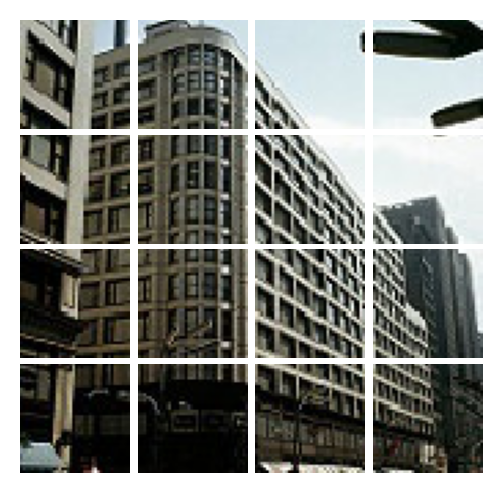

In [ ]:
i = np.random.randint(len(df_all))
TARGET_SIZE = (160,160)
im  = np.array(load_img(df_all.f[i], target_size=(TARGET_SIZE)))
segs = segment_image(im)

plt.figure(figsize = (3,3))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.05, hspace=0.05) 

for k in range(16):
    ax1 = plt.subplot(gs1[k])
    plt.axis('off')
    ax1.imshow(segs[k,:,:])

#### Dominant Colour
Expecting that image colour would be fairly telling of the image classificaton, forests would be predominantly green, glaciers would be predominantly white or grey, dominant image colour was determined. This operation was made easier by the "OpenCV" package, specifically the k-means clustering function. In many cases, the colour pallette does not vary significiantly whithin an image, however the pallette itself may be indicive of a classification.

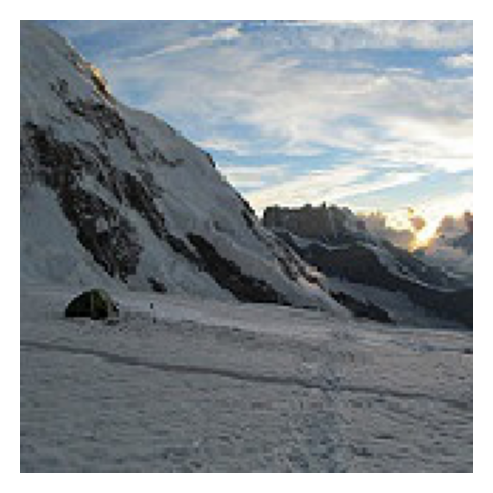

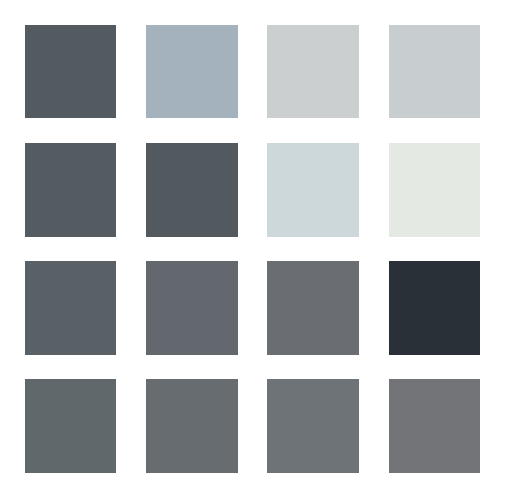

In [ ]:
i = np.random.randint(len(df_all))
im = np.array(load_img(df_all.f[i], target_size = TARGET_SIZE))
segs = segment_image(im)

plt.figure(figsize =(3,3))
plt.imshow(im)
plt.axis('off')
plt.show()


fig, ax = plt.subplots(4,4, figsize = (3,3))
j = 0
for k in ax:
    for axes in k:
        axes.bar(0,1,color = (find_dom_col(segs[j,:,:])/255.))
        axes.axis('off')
        j +=1
plt.show()

#### Colorfulness

Similar to the dominant colour, it is believed that the "colourfulness" of an image is likely indicative of the images class. The image colourfulness metric ranged from roughly 3, indicating not colourful, to roughly 199, indicating extremely colourful. As may be expected, images which were already in greyscale/ black-and-white had the lowest colourfulness scores. Something that was observed with the scores was that higher scores were generally assigned to images with more blues or brighter colours, rather than a more diverse colour presence. This may indicate the the colourfulness metric would not provided consistently expected scores. For the purposes of this study, it was deemed that any potential flaws within the metric were acceptable.

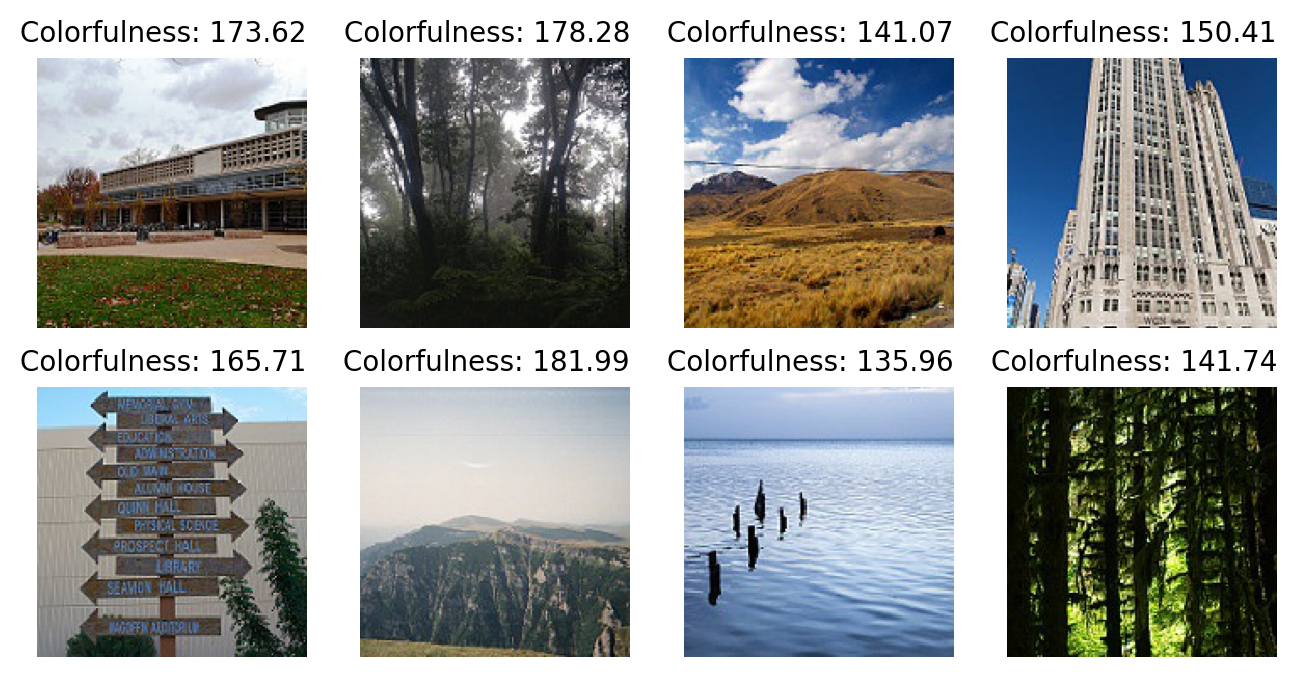

In [ ]:
rows = 2
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(8, 4))
sub_df = df_all.sample(rows*cols)
for i in range(rows):
    for j in range(cols):
        k = cols*i + j
        f = sub_df.iloc[k].f
        img = load_img(f, target_size=TARGET_SIZE)
        colorful = colorfulness(img)
        axes[i][j].imshow(img)
        axes[i][j].set_title(f"Colorfulness: {colorful :.2f}", fontsize=10, loc="right")
        axes[i][j].set_axis_off()
plt.show()

#### Greyscale Textures

To extact the image textures, the image processing library $scikit-image$ made calculating texture properties easy. In all cases, when determining the co-occurrence matricies, a constant distance of 5 pixels was used. While there are a number of texture properties easily calculable within these functuions, dissimilarity and correlation seemed to be the best suited for our purposes. 

#### Canny Edge Detection Filter
The final extraction method used on these images was the Canny edge detection filter. The figure below illustrates the stark differences compared to the original image. As you can see, characteristic edges run both horizontally and vertically. While they may not be exactly horizontal or vertical, because they occupy the majority of the image, their influence is still captured. While some shorter edges may not be fully considered in the full image, once split into the 16 segments, smaller details have more influence on extracted values.

By taking the maximum of the averages along each the X and Y axes, extended lenghts of characteristic edges can be quantified. Recording the maximim standard deviation along these axes may also provide meaningful parameters for the random forest model. 

Text(0.5, 1.0, 'Canny Edge Detected')

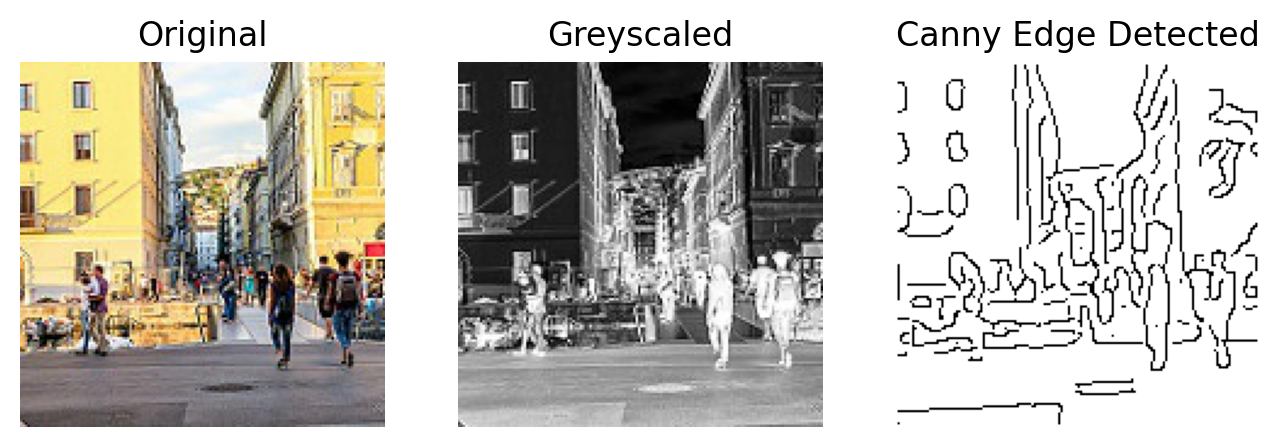

In [ ]:
im = np.array(load_img(df_all.f[14259]))

fig, ax = plt.subplots(1,3, figsize = (8,20))
for axes in ax:
    axes.axis('off')
ax[0].imshow(im)
ax[0].set_title('Original')
ax[1].imshow(lumin(im), cmap = "Greys")
ax[1].set_title('Greyscaled')
ax[2].imshow(feature.canny(lumin(im)/255.,2), cmap = "Greys")
ax[2].set_title('Canny Edge Detected')

#### Model Creation

Having extracted a number of features from the images, it is now possible to construct a random forest model. From the constructed dataframe, subsets of training data and testing/ validation data were split where 80% of the data is used for training and the remaining 20% for testing the trained model.

Using the default hyperparameters available in the SciKitLearn $RandomForestClassifier$ function, a model testing accuracy of 75% was obtained. With the available parameters, overfitting is likely a concern. Reviewing the training accuracy found a value of 100%, suggesting a considerable amount of overfitting. 

In [ ]:
# Random Forest
Y = col_df.cat
X = col_df.drop(['cat','fname'], axis = 1)
np.random.seed(42)
x_tr, x_te, y_tr, y_te = train_test_split(X,Y, test_size=0.2)

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_tr, y_tr)
y_pred_tr = rf.predict(x_tr)
y_pred_te = rf.predict(x_te)

acc_tr = np.mean(y_pred_tr == y_tr)
acc_te = np.mean(y_pred_te == y_te)

print(f'Initial Training accuracy: {acc_tr:.2f}')
print(f'Initial Testing accuracy: {acc_te:.2f}')

Initial Training accuracy: 1.00
Initial Testing accuracy: 0.75


To reduce the aggressive overfitting, the hyper parameters $n\_estimators$, $max\_depth$, and $max\_features$ were investigated. Manually testing these values found that most overfitting can be addressed by reducing the $max\_depth$ parameter.   

In [ ]:
acc_te_n_est = []
acc_tr_n_est =[]
x = range(1,100)

for i in x:
    rf = RandomForestClassifier(n_estimators=i, n_jobs=cpu_count())
    rf.fit(x_tr, y_tr)
    y_pred_tr = rf.predict(x_tr)
    y_pred_te = rf.predict(x_te)
    
    acc_tr_n_est.append(np.mean(y_pred_tr == y_tr))
    acc_te_n_est.append(np.mean(y_pred_te == y_te))

Text(0, 0.5, 'Accuracy')

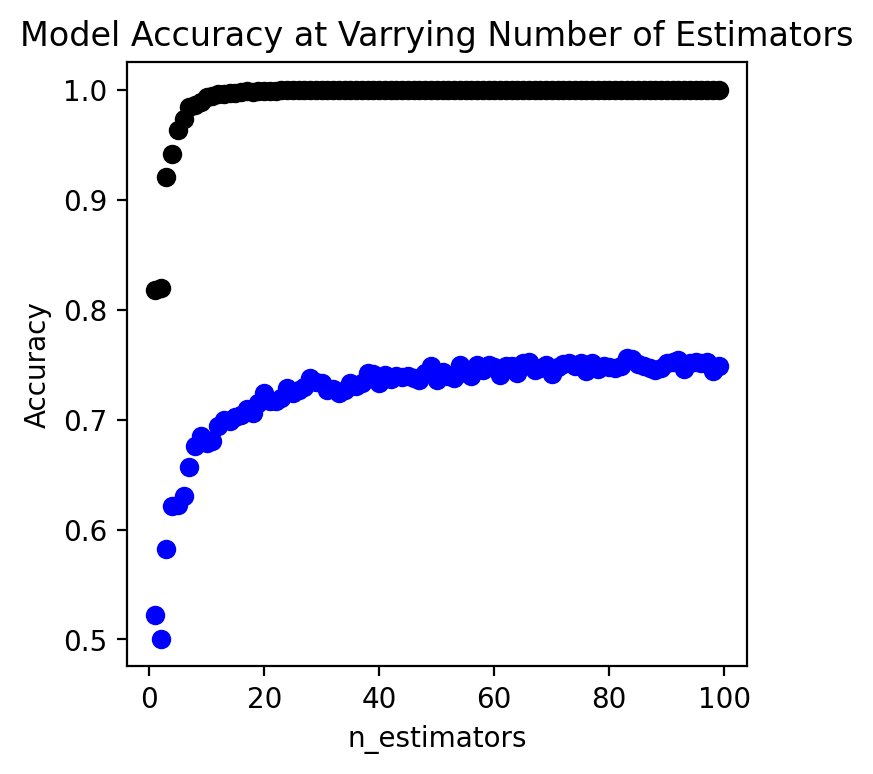

In [ ]:
x = range(1,100)
plt.figure(figsize = (4,4))
plt.plot(x,acc_tr_n_est,'ko', label ='Training Accuracy')
plt.plot(x,acc_te_n_est,'bo', label ='Testing Accuracy')
plt.title('Model Accuracy at Varrying Number of Estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [ ]:
acc_te_mx_dpth = []
acc_tr_mx_dpth =[]
x = range(1,30)

for i in x:
    rf = RandomForestClassifier(n_estimators=100, max_depth =i, n_jobs=cpu_count())
    rf.fit(x_tr, y_tr)
    y_pred_tr = rf.predict(x_tr)
    y_pred_te = rf.predict(x_te)
    
    acc_tr_mx_dpth.append(np.mean(y_pred_tr == y_tr))
    acc_te_mx_dpth.append(np.mean(y_pred_te == y_te))

Text(0, 0.5, 'Accuracy')

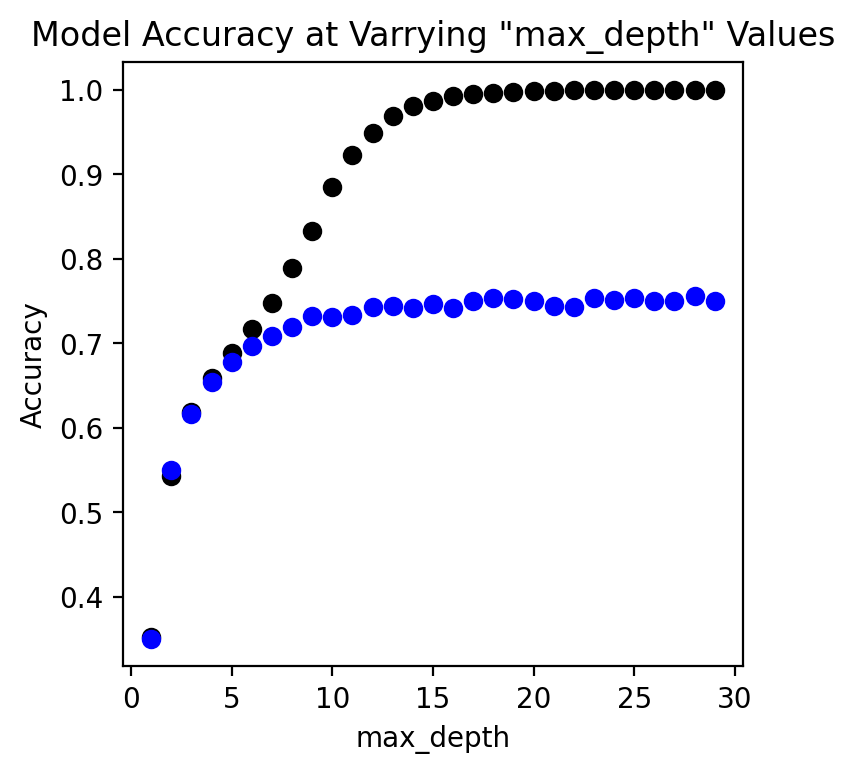

In [ ]:
x = range(1,30)
plt.figure(figsize = (4,4))
plt.plot(x,acc_tr_mx_dpth,'ko', label ='Training Accuracy')
plt.plot(x,acc_te_mx_dpth,'bo', label ='Testing Accuracy')
plt.title('Model Accuracy at Varrying "max_depth" Values')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [ ]:
acc_te_mx_feat = []
acc_tr_mx_feat =[]
x = range(1,100,2)

for i in x:
    rf = RandomForestClassifier(n_estimators=80, max_depth =6, max_features = i, n_jobs=-1)
    rf.fit(x_tr, y_tr)
    y_pred_tr = rf.predict(x_tr)
    y_pred_te = rf.predict(x_te)
    
    acc_tr_mx_feat.append(np.mean(y_pred_tr == y_tr))
    acc_te_mx_feat.append(np.mean(y_pred_te == y_te))

Text(0, 0.5, 'Accuracy')

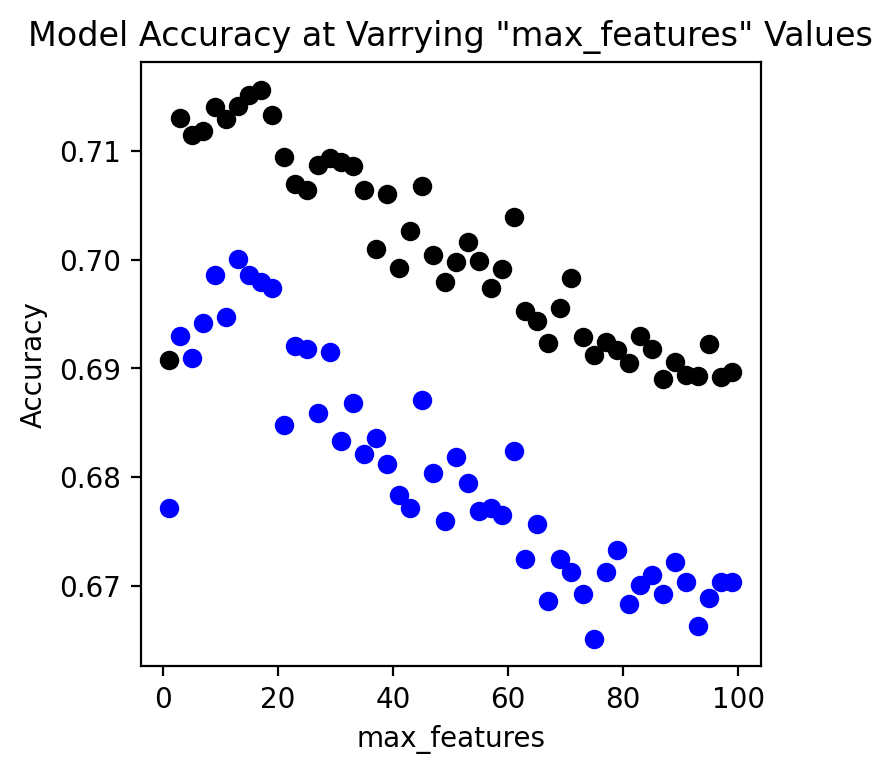

In [ ]:
x = range(1,100,2)
plt.figure(figsize = (4,4))
plt.plot(x,acc_tr_mx_feat,'ko', label ='Training Accuracy')
plt.plot(x,acc_te_mx_feat,'bo', label ='Testing Accuracy')
plt.title('Model Accuracy at Varrying "max_features" Values')
plt.xlabel('max_features')
plt.ylabel('Accuracy')

For the final random forest model, we chose n_estimators to be 80, max_depth to be 6 and max_features to be 15. From this model, a testing accuracy of 69.9% and training accuracy of 71.5% were obtained. While it would have been possible to use the GridSearchCV function to automatically determine suitable hyper-parameters, due to the wide search range, it was more effecient to investigate manually.

In [ ]:
np.random.seed(42)
rf = RandomForestClassifier(n_estimators = 80, max_depth =6,max_features = 15, n_jobs = cpu_count())
rf.fit(x_tr, y_tr)
y_pred_tr = rf.predict(x_tr)
y_pred_te = rf.predict(x_te)

acc_tr = np.mean(y_pred_tr == y_tr)
acc_te = np.mean(y_pred_te == y_te)

print(f'Tuned Random Forest Training Accuracy: {acc_tr*100 :.2f}%')
print(f'Tuned Random Forest Testing Accuracy: {acc_te*100 :.2f}%')

Tuned Random Forest Training Accuracy: 71.54%
Tuned Random Forest Testing Accuracy: 69.89%


Curious as to which features the model believed to be significant, the feature importances were determined. It was found that features associated to the Canny edge detection were, in general, considered more significant. This is seen as the majority of the top feature importances are some measure extracted from the Canny filter. 

Text(0.5, 0, 'Importance')

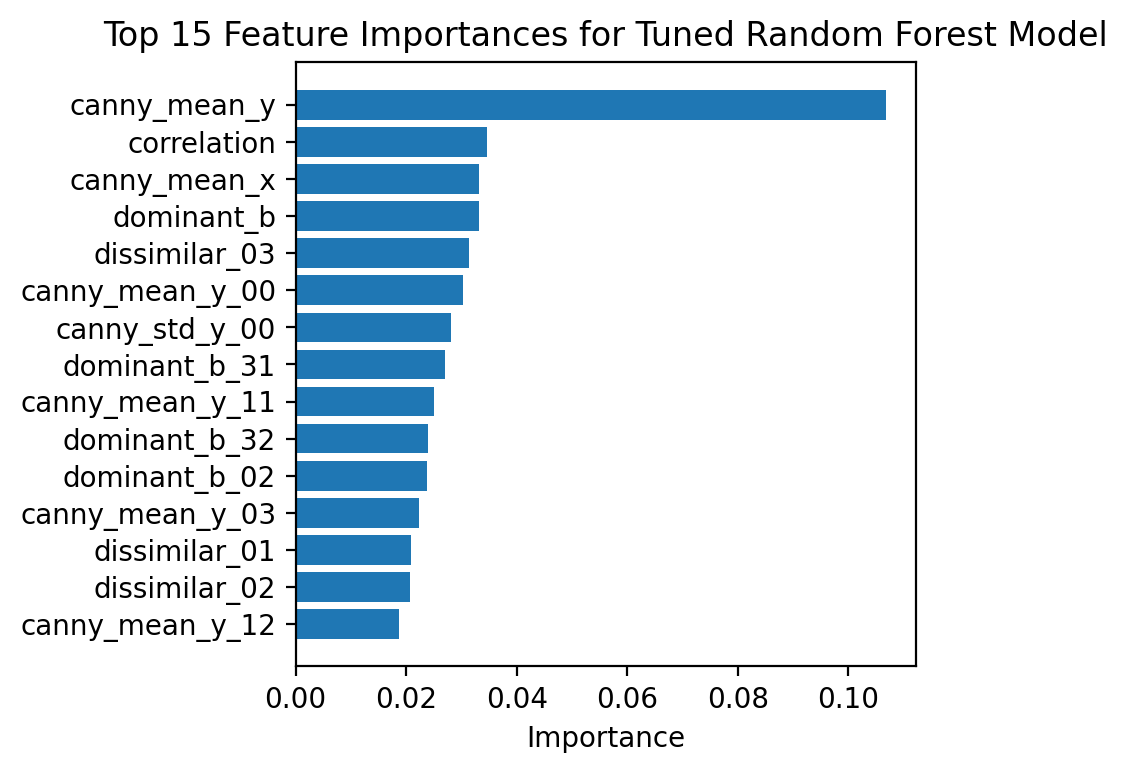

In [ ]:
I = np.argsort(rf.feature_importances_)[-15:]
important_features = [X.columns[i] for i in I]

plt.figure(figsize =(4,4))
plt.barh(important_features,rf.feature_importances_[I])
plt.title('Top 15 Feature Importances for Tuned Random Forest Model')
plt.xlabel('Importance')

### Hand Rolled Convolutional Neural Network

We used a sequential model for our hand-rolled CNN. 
- The first block consists of a convolutional layer with a filter size of 32 and a kernel size of (5,5) and max pooling layer of size (2,2).
- The next three blocks consist of convolutional layers with filter sizes of 64, 96, and 128. Each having a kernel size of (3,3) and max pooling layers of size (2,2).
- The output from these is flattened and sent to a dense layer of size 512.
- This dense layer is then sent finally to a final dense layer of size 6 with a soft max activation.

The results of this model trained on 40 epochs with the Adam optimizer and loss computed with the categorical crossentropy function gave us a computed training accuracy of 90.57% with a training loss of 0.2458. The computed Validation accuracy was 86.98% with a validation loss of 0.4341. Using the provided testing set we computed a testing accuracy of 87.7%. We also attempted to add dropout to the model which lowered the validation accuracy to ~80%.


In [ ]:
df_tr_samp = df_train.sample(frac=1).reset_index(drop=True) # shuffle the dataset
df_tr_samp.head()

f  ...          y
0  kaggle_intel_classification_data/Data/seg_trai...  ...  buildings
1  kaggle_intel_classification_data/Data/seg_trai...  ...     street
2  kaggle_intel_classification_data/Data/seg_trai...  ...     forest
3  kaggle_intel_classification_data/Data/seg_trai...  ...     forest
4  kaggle_intel_classification_data/Data/seg_trai...  ...  buildings

[5 rows x 3 columns]

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5),padding='Same', activation= 'relu', input_shape=(*TARGET_SIZE,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dense(6, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 18, 128)      

In [ ]:
training_gen = ImageDataGenerator(rescale=1/255.,
    shear_range=0.2,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=1/3)

training_flow = training_gen.flow_from_dataframe(
    dataframe=df_tr_samp,
    x_col="x",
    y_col="y",
    target_size=TARGET_SIZE,
    class_mode="categorical",
    subset="training")

validation_flow = training_gen.flow_from_dataframe(
    dataframe=df_tr_samp,
    x_col="x",
    y_col="y",
    target_size=TARGET_SIZE,
    class_mode="categorical",
    subset="validation")

testing_gen = ImageDataGenerator(rescale=1/255.)

testing_flow = testing_gen.flow_from_dataframe(
    dataframe=df_test,
    x_col="x",
    y_col="y",
    batch_size=len(df_test),
    target_size=TARGET_SIZE,
    class_mode="categorical")


Found 9356 validated image filenames belonging to 6 classes.
Found 4678 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames belonging to 6 classes.


In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
simple_cnn = model.fit(training_flow, validation_data=validation_flow, epochs=40)

Epoch 1/40
293/293 [==============================] - 78s 265ms/step - loss: 1.3206 - accuracy: 0.4509 - val_loss: 0.9508 - val_accuracy: 0.6152
Epoch 2/40
293/293 [==============================] - 76s 260ms/step - loss: 0.9424 - accuracy: 0.6233 - val_loss: 0.8957 - val_accuracy: 0.6255
Epoch 3/40
293/293 [==============================] - 76s 260ms/step - loss: 0.7984 - accuracy: 0.6995 - val_loss: 0.6625 - val_accuracy: 0.7599
Epoch 4/40
293/293 [==============================] - 77s 265ms/step - loss: 0.6684 - accuracy: 0.7543 - val_loss: 0.7029 - val_accuracy: 0.7433
Epoch 5/40
293/293 [==============================] - 77s 263ms/step - loss: 0.6151 - accuracy: 0.7725 - val_loss: 0.5607 - val_accuracy: 0.7993
Epoch 6/40
293/293 [==============================] - 78s 268ms/step - loss: 0.5664 - accuracy: 0.7939 - val_loss: 0.6465 - val_accuracy: 0.7715
Epoch 7/40
293/293 [==============================] - 78s 267ms/step - loss: 0.5392 - accuracy: 0.8015 - val_loss: 0.5370 - val_ac

In [ ]:
model.save("simple_cnn_model.h5")

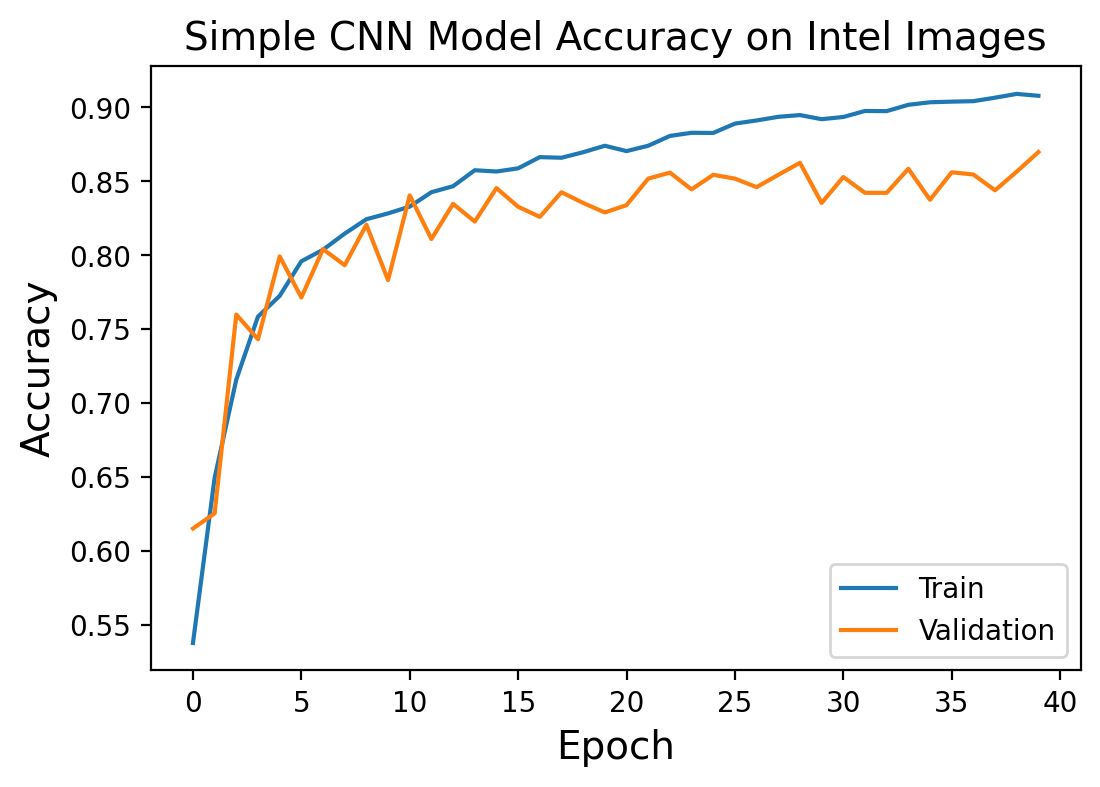

In [ ]:
plt.plot(simple_cnn.history['accuracy'])
plt.plot(simple_cnn.history['val_accuracy'])
plt.title('Simple CNN Model Accuracy on Intel Images', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

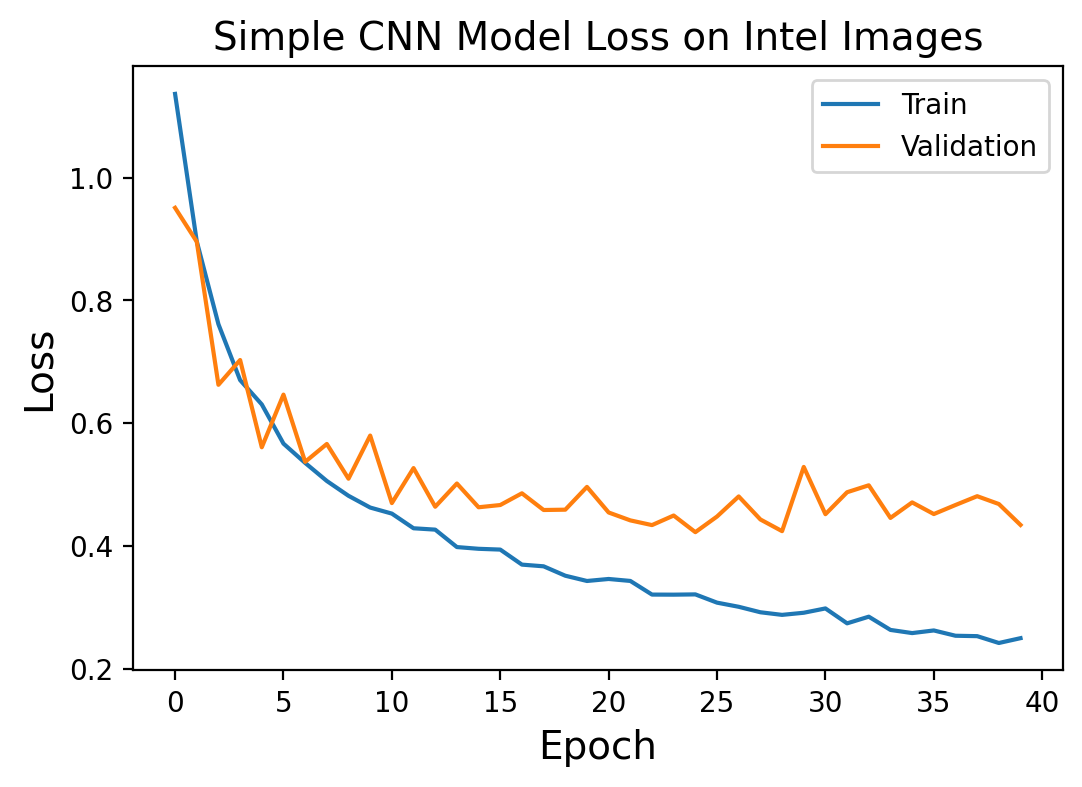

In [ ]:
plt.plot(simple_cnn.history['loss'])
plt.plot(simple_cnn.history['val_loss'])
plt.title('Simple CNN Model Loss on Intel Images', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
X_test, y_test = next(testing_flow)
y_pred = model.predict(X_test)
np.mean(y_test.argmax(axis=1) == y_pred.argmax(axis=1))

0.877

### Custom CNN Model 
#### Visual Geometry Group 16 (VGG-16) Model

The Visual Geometry Group (VGG-16) 16 Model was originally created at the Univeristy of Oxford as part of the 2014 ImageNet Large Scale Visual Recognition Challenge (ILSVRC) competeition (Simonyan & Zisserman 2015). This model held the number one spot for a number of years before being beaten out by newer models such as ResNet, Inception, and EfficientNet.

The original VGG-16 model consists of
- One block consisting of 2 of Convollition layers (kernel size 3) with 64 filters and 1 max pooling layer
- One block consisting of 2 of Convollition layers (kernel size 3) with 128 filters and 1 max pooling layer.
- One block consisting of 2 of Convollition layers (kernel size 3) with 256 filters followed by 1 max pooling layer.
 - Two blocks consisting of 2 Convollition layers with 512 filters (kernel size 3) followed by 1 max pooling layer.
- 3 Fully connected blocks.

#### Custom Visual Geometry Group 16 (VGG-16) Model

#### Custom VGG-16 Model

In this section we create a customized version of the VGG-16 model. However, we modify the model in several ways. For instance, we only have 4 Convolution and max pooling blocks instead of 5. Each convolution block has only one layer instead of being grouped in twos and threes. We also omit the dropout layers that are somtimes used in the VGG-16 model as these had a negative affect on results. We keep the kernel sizes and the same as well as keep the filter progression the same (64, 128, 256, 512). In total the model has approximatley 31 million parameters, all of which are trainable. Our goal in the next section is to compare this customized model against a partially pre-trained version of the VGG-16 model using weights from the ImageNet version of the model. 

The custom model struture is as follows:
  - 4 Convolutional/Max Pooling blocks each with filters of 64, 128, 256, an 512 (kernal size of 3).
  - 2 Fully connected blocks.
  - 1 Softmax activation layer.

We use the "Adam" optimizer with the deafault learning rate of $0.001$ and the Categorical Crossentropy loss function. The model was trained for 50 epochs, which resulted in a training accuracy of $91.51$% and a validation accuracy of $84.95$%. The training loss was $0.2473$ and the validation loss was $0.4199$.

In [ ]:
def ConvBlock(model, layers, filters):
  for i in range(layers):
    model.add(Conv2D(filters, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
def CUSTOM_VGG_16():
  model = Sequential()
  model.add(Lambda(lambda x: x, input_shape=(150, 150, 3)))
  ConvBlock(model, 1, 64)
  ConvBlock(model, 1, 128)
  ConvBlock(model, 1, 256)
  ConvBlock(model, 1, 512)
  model.add(Flatten())
  model.add(Dense(1024,activation='relu'))
  model.add(Dense(4096,activation='relu'))
  model.add(Dense(6,activation='softmax'))
  return model

In [ ]:
custom_vgg16_model = CUSTOM_VGG_16()
custom_vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 256)       0

In [ ]:
# Complie Custom VGG-16 Model
optimizer = Adam(lr = 0.001) #Adam(lr=2*10**-4)
custom_vgg16_model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
custom_vgg16_model_history = custom_vgg16_model.fit(training_flow, validation_data = validation_flow, epochs = 50)

Epoch 1/50
293/293 [==============================] - 116s 282ms/step - loss: 1.5187 - accuracy: 0.3570 - val_loss: 0.9991 - val_accuracy: 0.5949
Epoch 2/50
293/293 [==============================] - 80s 273ms/step - loss: 0.9957 - accuracy: 0.5954 - val_loss: 0.8818 - val_accuracy: 0.6407
Epoch 3/50
293/293 [==============================] - 80s 275ms/step - loss: 0.9201 - accuracy: 0.6303 - val_loss: 0.8016 - val_accuracy: 0.6984
Epoch 4/50
293/293 [==============================] - 80s 275ms/step - loss: 0.8124 - accuracy: 0.6907 - val_loss: 0.8970 - val_accuracy: 0.6509
Epoch 5/50
293/293 [==============================] - 80s 274ms/step - loss: 0.7463 - accuracy: 0.7266 - val_loss: 0.7735 - val_accuracy: 0.6892
Epoch 6/50
293/293 [==============================] - 80s 274ms/step - loss: 0.6709 - accuracy: 0.7527 - val_loss: 0.6166 - val_accuracy: 0.7693
Epoch 7/50
293/293 [==============================] - 81s 275ms/step - loss: 0.6362 - accuracy: 0.7636 - val_loss: 0.6200 - val_a

In [ ]:
custom_vgg16_model.save("custom_vgg16_model.h5")

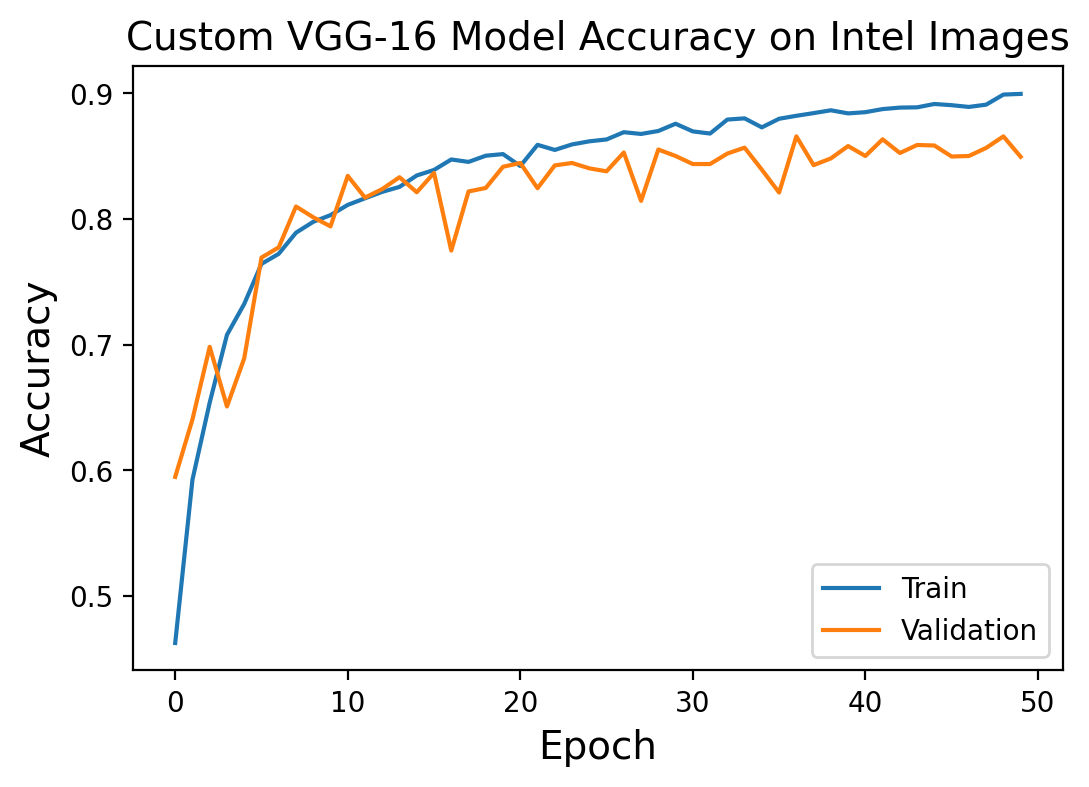

In [ ]:
plt.plot(custom_vgg16_model_history.history['accuracy'])
plt.plot(custom_vgg16_model_history.history['val_accuracy'])
plt.title('Custom VGG-16 Model Accuracy on Intel Images', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

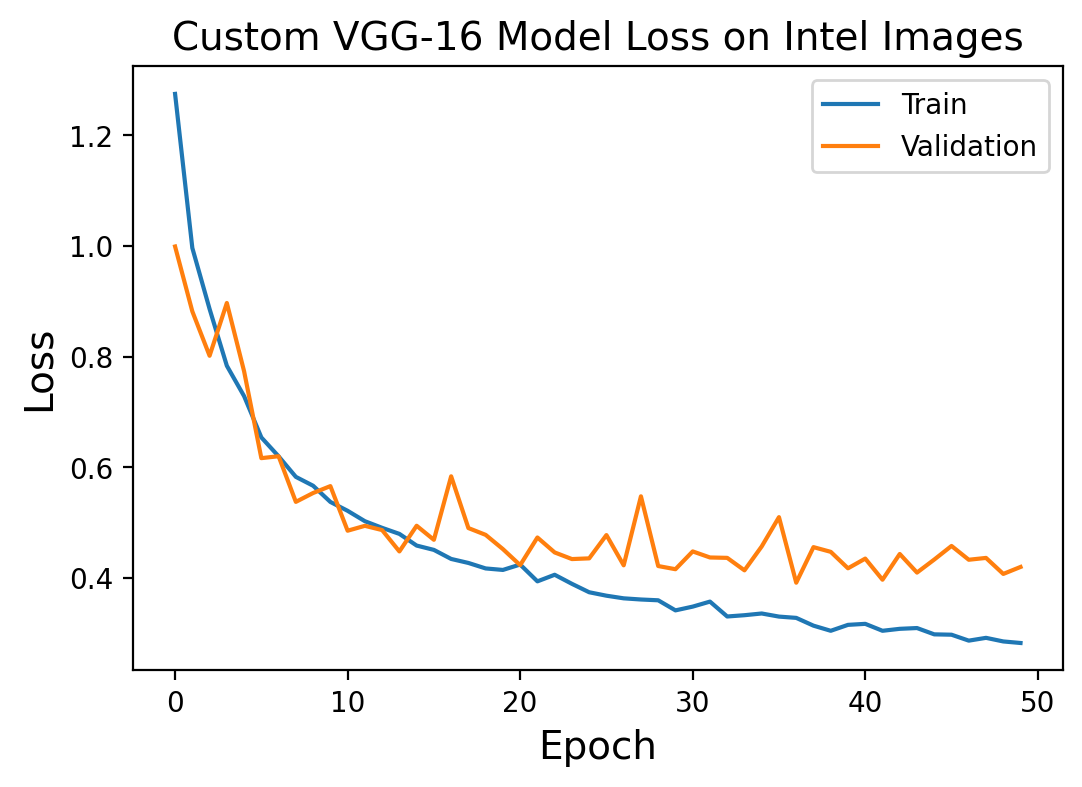

In [ ]:
plt.plot(custom_vgg16_model_history.history['loss'])
plt.plot(custom_vgg16_model_history.history['val_loss'])
plt.title('Custom VGG-16 Model Loss on Intel Images', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
testing_flow = testing_gen.flow_from_dataframe(
    dataframe = df_test,
    x_col = "x",
    y_col = "y",
    batch_size = 1,
    shuffle = False,
    target_size = (150,150),
    class_mode = "categorical")

custom_vgg16_model = tf.keras.models.load_model("custom_vgg16_model.h5")
y_pred1 = custom_vgg16_model.predict(testing_flow)

Found 3000 validated image filenames belonging to 6 classes.


### Transfer Learning

In this section we take advantage of the pre-trained version of the VGG-16 Model from Oxford with the ImageNet model weights. We omit the fully connected and dropout blocks in place of a global averaging pool with one dropout layer. This gives us a model with around 15 million parameters of which about 265,000 are trainiable. We use the same optimizer, loss function, and number of training epochs as we did in the previous section. We cannot apply the complete pre-trained VGG-16 model here because even though it has 1000 different classes they focus on object and animals/plants and do not focus on scenerey or landscapes. When attempting to apply that here we had some hilarious results, many times the model return mosquito nets, shower curtains or even Band-Aids. So instead we are forced to re-train the model on the dataset.

Suprisingly, this model performed slighlty worse than the custom model did. However, the two models are still relavivley comparable to each other. We obtained a training accuracy of $86.44$%, but the validation accuracy was similar at $85.58$%. The training loss was $0.3485$ and $0.3875$ for the validation loss, again comparable to the custom model.

We then applied the custom model and the transfer model to the 3000 different testing images and compare the results. During testing the two models performed equally as well. We found that the custom model had an accuracy of $86.80$% and the transfer learning model had and accuracy of $86.97$%. The two models agreed with each other $84.73$% of the time. Looking at the confusion matrices below, it seems that both models are the most confused between mountains and glaciers, as well as streets and buildings.

In [ ]:
vgg16_base_model = VGG16(include_top = False, weights = 'imagenet',  
                         input_shape = (150,150,3), pooling = 'avg')
vgg16_base_model.trainable = False

x = Dense(512, activation='relu')(vgg16_base_model.output)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)

vgg16_transfer_model = Model(vgg16_base_model.input, x) 
vgg16_transfer_model.compile(optimizer = 'Adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

vgg16_transfer_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
vgg16_transfer_model_history = vgg16_transfer_model.fit(
                                training_flow,
                                validation_data = validation_flow,
                                epochs = 50)

Epoch 1/50
293/293 [==============================] - 89s 291ms/step - loss: 1.0027 - accuracy: 0.6103 - val_loss: 0.5229 - val_accuracy: 0.8065
Epoch 2/50
293/293 [==============================] - 82s 280ms/step - loss: 0.5653 - accuracy: 0.7917 - val_loss: 0.4724 - val_accuracy: 0.8271
Epoch 3/50
293/293 [==============================] - 82s 281ms/step - loss: 0.5121 - accuracy: 0.8105 - val_loss: 0.4813 - val_accuracy: 0.8155
Epoch 4/50
293/293 [==============================] - 85s 289ms/step - loss: 0.5076 - accuracy: 0.8127 - val_loss: 0.4502 - val_accuracy: 0.8301
Epoch 5/50
293/293 [==============================] - 82s 281ms/step - loss: 0.4604 - accuracy: 0.8283 - val_loss: 0.4455 - val_accuracy: 0.8301
Epoch 6/50
293/293 [==============================] - 82s 279ms/step - loss: 0.4575 - accuracy: 0.8268 - val_loss: 0.4498 - val_accuracy: 0.8367
Epoch 7/50
293/293 [==============================] - 81s 276ms/step - loss: 0.4551 - accuracy: 0.8303 - val_loss: 0.4305 - val_ac

In [ ]:
vgg16_transfer_model.save("vgg16_transfer_model.h5")

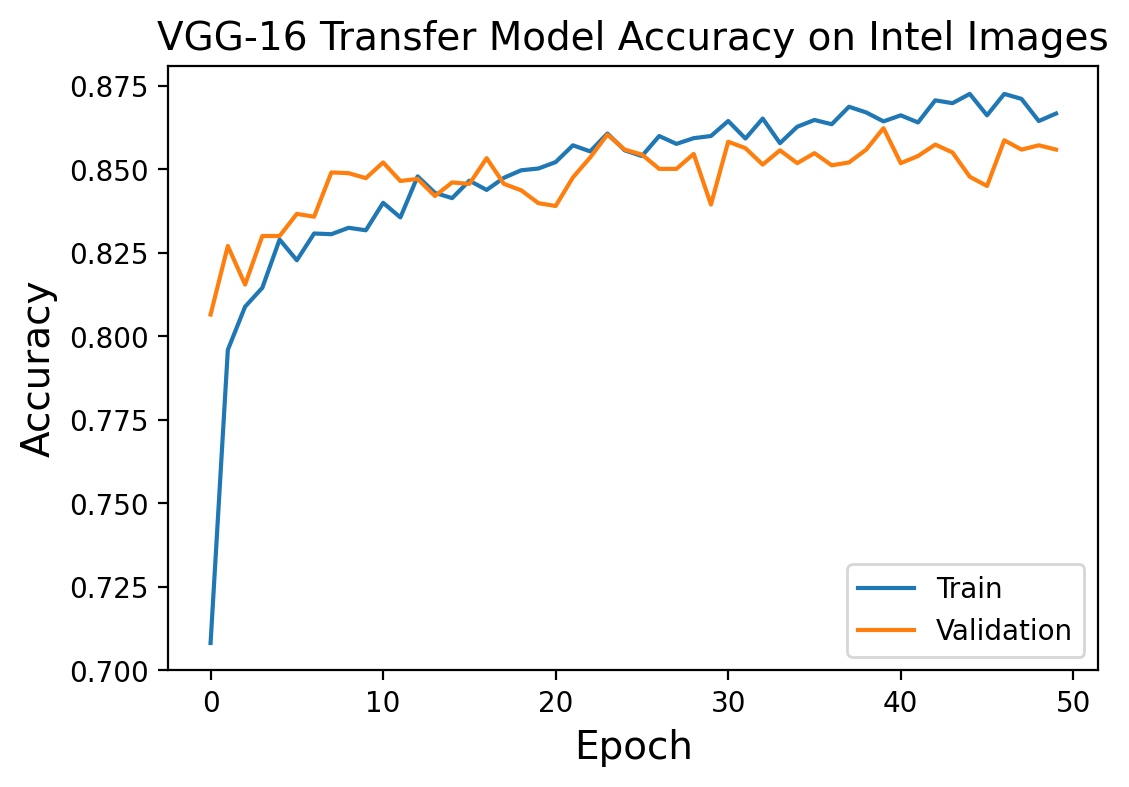

In [ ]:
plt.plot(vgg16_transfer_model_history.history['accuracy'])
plt.plot(vgg16_transfer_model_history.history['val_accuracy'])
plt.title('VGG-16 Transfer Model Accuracy on Intel Images', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

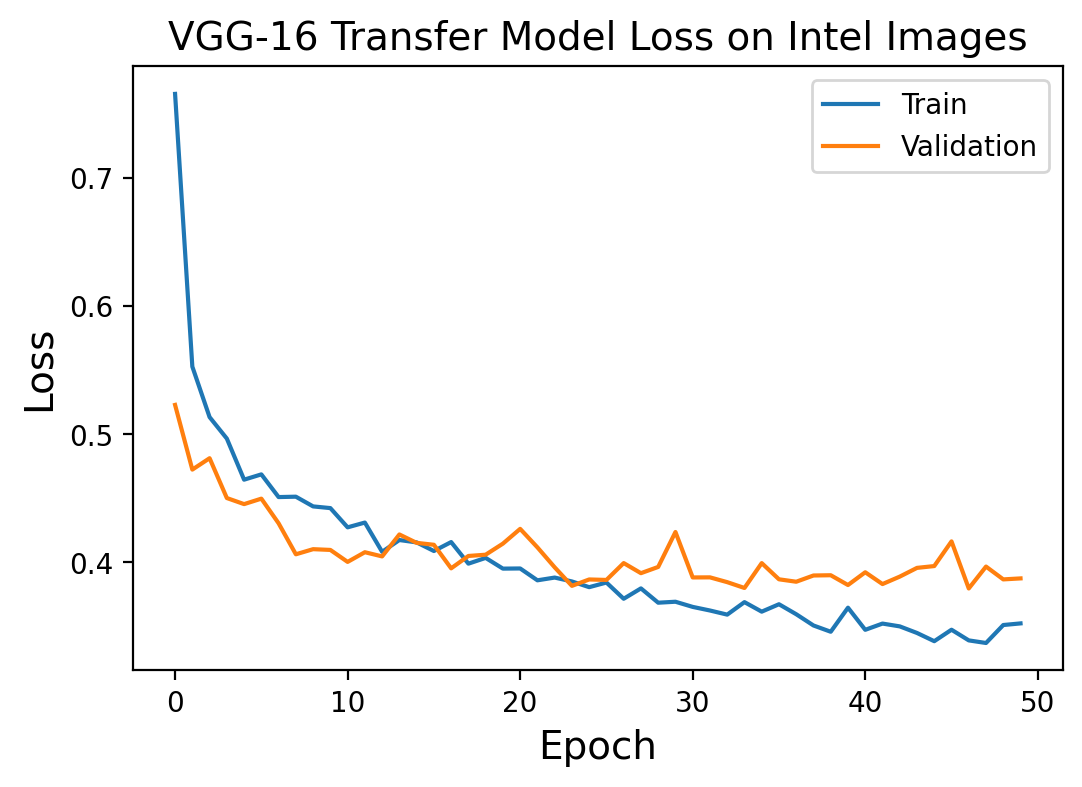

In [ ]:
plt.plot(vgg16_transfer_model_history.history['loss'])
plt.plot(vgg16_transfer_model_history.history['val_loss'])
plt.title('VGG-16 Transfer Model Loss on Intel Images', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

In [ ]:
testing_flow = testing_gen.flow_from_dataframe(
    dataframe = df_test,
    x_col = "x",
    y_col = "y",
    batch_size = 1,
    shuffle = False,
    target_size = (150,150),
    class_mode = "categorical")

vgg16_transfer_model = tf.keras.models.load_model('vgg16_transfer_model.h5')
y_pred2 = vgg16_transfer_model.predict(testing_flow)

Found 3000 validated image filenames belonging to 6 classes.


In [ ]:
y_classes1 = y_pred1.argmax(axis=-1)
y_classes2 = y_pred2.argmax(axis=-1)
print(y_classes1, y_classes2)

[0 5 5 ... 4 3 3] [0 5 5 ... 4 3 3]


In [ ]:
label_map = (testing_flow.class_indices)
print(label_map)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


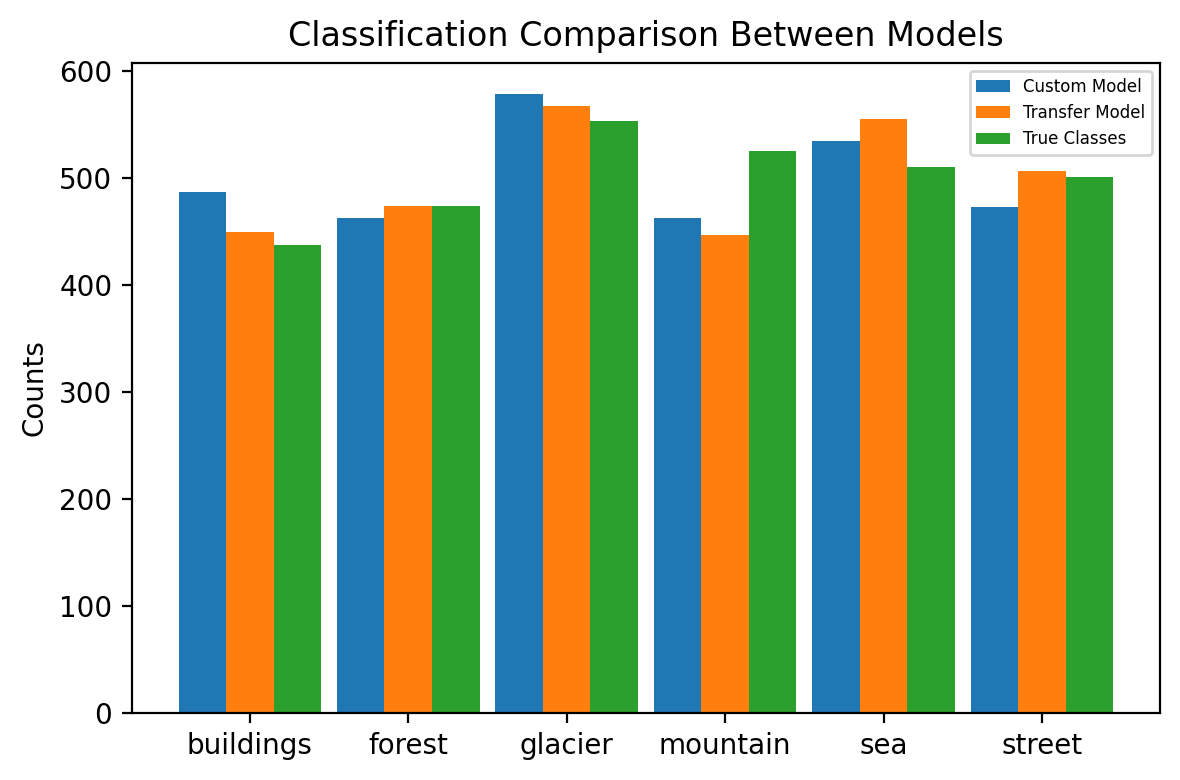

In [ ]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

counts1 = [np.count_nonzero(y_classes1 == 0), np.count_nonzero(y_classes1 == 1), 
           np.count_nonzero(y_classes1 == 2), np.count_nonzero(y_classes1 == 3),
           np.count_nonzero(y_classes1 == 4), np.count_nonzero(y_classes1 == 5)]

counts2 = [np.count_nonzero(y_classes2 == 0), np.count_nonzero(y_classes2 == 1), 
           np.count_nonzero(y_classes2 == 2), np.count_nonzero(y_classes2 == 3),
           np.count_nonzero(y_classes2 == 4), np.count_nonzero(y_classes2 == 5)]

#print(y_classes1, y_classes2, counts1, counts2)

true_counts = [np.count_nonzero(df_test['y'] == 'buildings'), np.count_nonzero(df_test['y'] == 'forest'), 
               np.count_nonzero(df_test['y'] == 'glacier'), np.count_nonzero(df_test['y'] == 'mountain'),
               np.count_nonzero(df_test['y'] == 'sea'), np.count_nonzero(df_test['y'] == 'street')]

ind = np.arange(len(class_names))
width = 0.3

fig, ax = plt.subplots()
ax.bar(ind - width/3, counts1, width, label = 'Custom Model')
ax.bar(ind + 2*width/3, counts2, width, label = 'Transfer Model')
ax.bar(ind + 5*width/3, true_counts, width, label = 'True Classes')
ax.set_xticks(ind+2*width/3)
ax.set_xticklabels(class_names)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Classification Comparison Between Models')
ax.legend(fontsize = 6)
fig.tight_layout()
plt.show()

In [ ]:
classes = {0:'buildings', 1:'forest', 2:'glacier', 3:'mountain',4:'sea',5:'street'}
y_classes1 = list((pd.Series(y_classes1)).map(classes)) 
y_classes2 = list((pd.Series(y_classes2)).map(classes))

print(y_classes1)
print(y_classes2)

['buildings', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'buildings', 'buildings', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'buildings', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'mountain', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'street', 'sea', 'street', 'street', 'street', 'street', 'buildings', 'street', 'street', 'stre

In [ ]:
print('True Class Counts', np.array(true_counts))
print('Difference in Custom Model Predictions:', np.array(true_counts)-np.array(counts1))
print('Difference in Transfer Model Predictions:', np.array(true_counts)-np.array(counts2))

True Class Counts [437 474 553 525 510 501]
Difference in Custom Model Predictions: [-50  11 -26  62 -25  28]
Difference in Transfer Model Predictions: [-13   0 -14  78 -45  -6]


In [ ]:
new_df = pd.DataFrame(columns=['file_name', 'True Class','Custom Model Prediction', 'Transfer Model Prediction', 'Agreement'])
new_df['file_name'] = df_test['f']
new_df['True Class'] = df_test['y']
new_df['Custom Model Prediction'] = y_classes1
new_df['Transfer Model Prediction'] = y_classes2
new_df['Agreement'] = np.where(new_df['Custom Model Prediction'] == new_df['Transfer Model Prediction'], True, False)
new_df

file_name  ... Agreement
0     kaggle_intel_classification_data/Data/seg_test...  ...      True
1     kaggle_intel_classification_data/Data/seg_test...  ...      True
2     kaggle_intel_classification_data/Data/seg_test...  ...      True
3     kaggle_intel_classification_data/Data/seg_test...  ...      True
4     kaggle_intel_classification_data/Data/seg_test...  ...      True
...                                                 ...  ...       ...
2995  kaggle_intel_classification_data/Data/seg_test...  ...     False
2996  kaggle_intel_classification_data/Data/seg_test...  ...     False
2997  kaggle_intel_classification_data/Data/seg_test...  ...      True
2998  kaggle_intel_classification_data/Data/seg_test...  ...      True
2999  kaggle_intel_classification_data/Data/seg_test...  ...      True

[3000 rows x 5 columns]

In [ ]:
a = np.where((new_df['Custom Model Prediction'] == new_df['True Class']), True, False)
b = np.where((new_df['Transfer Model Prediction'] == new_df['True Class']), True, False)
custom_acc = (np.count_nonzero(a == True)/len(new_df))*100
tranfer_acc = (np.count_nonzero(b == True)/len(new_df))*100
print(f'The custom model is correct {custom_acc:.2f}% of the time')
print(f'The transfer learning model is correct {tranfer_acc:.2f}% of the time')

The custom model is correct 86.80% of the time
The transfer learning model is correct 86.97% of the time


In [ ]:
agree = (len(new_df[new_df['Agreement'] == True])/len(new_df))*100
print(f'The models agree with each other {agree:.2f}% of the time')

The models agree with each other 84.73% of the time


In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
matrix1 = metrics.confusion_matrix(df_test['y'], y_classes1)
matrix2 = metrics.confusion_matrix(df_test['y'], y_classes2)

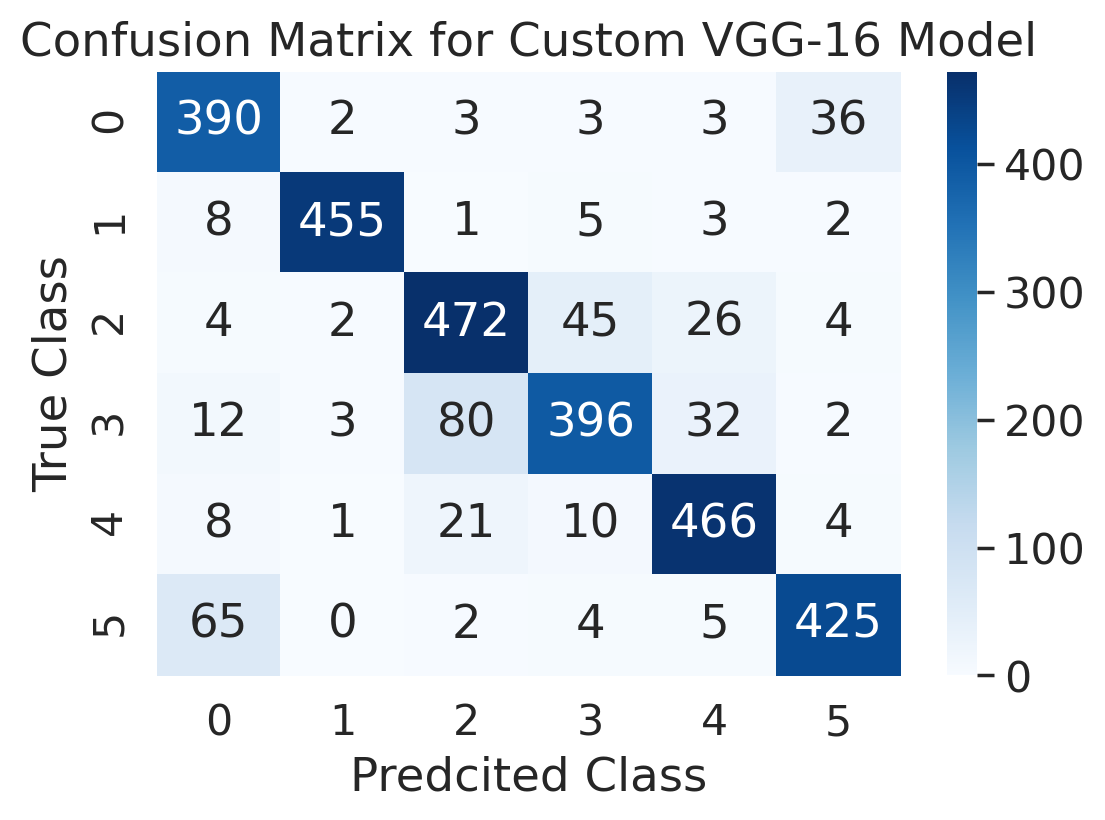

In [ ]:
import seaborn as sn
df_cm1 = pd.DataFrame(matrix1, range(6), range(6))
sn.set(font_scale=1.4)
sn.heatmap(df_cm1, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for Custom VGG-16 Model')
plt.ylabel('True Class')
plt.xlabel('Predcited Class')
plt.show()

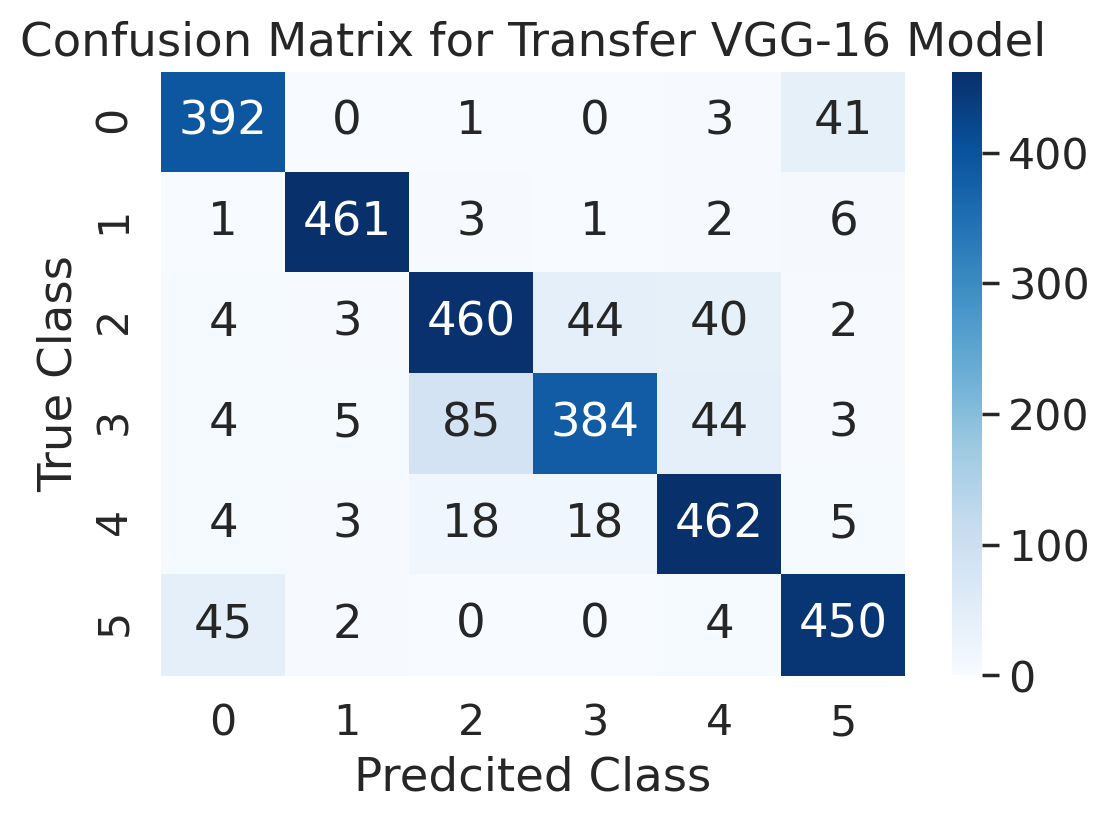

In [ ]:
df_cm2 = pd.DataFrame(matrix2, range(6), range(6))
sn.set(font_scale = 1.4) # for label size
sn.heatmap(df_cm2, annot = True, cmap = 'Blues', fmt = 'g')
plt.title('Confusion Matrix for Transfer VGG-16 Model')
plt.ylabel('True Class')
plt.xlabel('Predcited Class')
plt.show()

## Future Work

While it was seen that our approach to the random forest model creates a plausable model, there are aspects which could be changed to potentially improve the overall accuracy. As it was seen that the Canny filter was the most common important feature, more aspects could be extracted from that. Presently, our extraction from the Canny filtered image are limited to directly along the x and y axes. Allowing for a buffer angle would allow for features which are nearly horizontal or vertical to be more realistically weighted. Additionally, as it was seen that some features were not found to be significantly important to the model predictions, culling the list of extracted features would likely improve the model fit as well as the effeciency.  

## Conclusions

With the random forest classifier model, after tuning, a testing accuracy of 69.5% was obtained with relatively little overfitting. This model was constructed from features extracted from each image including colour, texture, and edge information. While it was shown that it is possible to construct the model, it is not the best suited approach for the given data type. Additionally, the utilized features were in no way exhaustive of what could be extracted from an image. As it was seen, there are parameters which were found to be more signifiant than others, indicating that it may be possible to reduce the work required for the initial feature extraction. For this data, the CNN models are better suited.

With our hand-rolled CNN model we computed an 86.25% validation accuracy with 0.4240 validation loss. While having a training accuracy of 89.57% with a training loss of 0.2865. We believe that our results are reasonable, while there is still some room for improvement. Perhaps we could have performed some more fine tuning on our filter and kernel sizes, or experimented with putting dropout in different parts of the sequential model. It is possible that if we used the hyperas python package we could have done more fine tuning of our hyper parameters.

Although our custom VGG-16 model achieved the highest training accuracy out of all the models we tried at 91.51% and a training loss of 0.2473. The model could never achieve a validation accuracy higher than any of the other CNN models at $\approx 85$%. Contrary to our expectations the transfer learning model did slightly worse with training and validation accuracies of 86.44% and 85.58% respectivley. This may be due to the original omdel weights from ImageNet being meant for another type of classification. In practice, both the custom VGG-16 model and the transfer learning VGG-16 model were very comparable with the custom model achieveing a testing accuracy of 86.80% and the tranfer model reaching 86.97% testing accuracy. We spectulate that the difficult nature of the images was one of the contributing factors to our models never breaking 90% accuracy. Many images are at odd perspectives or have other unrelated objects or animals in them. Even we would have guessed wrong on some of the images if we weren't told before hand what they were supposed to be.  

## References
Demlehner Q., Schoemer D., Laumer S., 2021, "How can artificial intelligence enhance car manufacturing? A Delphi study-based identification and assessment of general use cases", International Journal of Information Management,Volume 58,2021,https://doi.org/10.1016/j.ijinfomgt.2021.102317.

Kairinos N., 2019, "The integration of biometrics and AI", Biometric Technology Today,Volume 2019, Issue 5, 2019, Pages 8-10, https://doi.org/10.1016/S0969-4765(19)30069-4

Aickelin U., Jia Y., Sun P., Susanto R., 2020, "Ever Wondered What Your Pet is Thinking?", University of Melbourne, School of Computing and Information Systems (CIS), https://pursuit.unimelb.edu.au/articles/ever-wondered-what-your-pet-is-thinking

Moravec H., 1988, "Mind Children: The future of Robot and Human Intelligence", Harvard University Press, USA

LeCun Y., Bengio Y., Hinton G., 2015 "Deep Learning", Nature 521(7553), 436-444, https://doi.org/10.1038/nature14539

Intel challenge, 2018, "Intel scene Classification Challenge" Data retrieved from Kaggle: https://www.kaggle.com/puneet6060/intel-image-classification

Hasler D., Susstrunk S., 2003, "Measuring Colorfulness in Natural Images", The International Society for Optical Engineering,https://doi.org/10.1117/12.477378

Simonyan, Karen, and Andrew Zisserman, 2015, “Very Deep Convolutional Networks for Large-Scale Image Recognition.” ArXiv:1409.1556 [Cs], Apr. 2015. arXiv.org, http://arxiv.org/abs/1409.1556.